# 0.0 Imports





In [17]:
import math
import json
import requests
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import pickle
import xgboost as xgb

from boruta import BorutaPy
from scipy import stats as ss
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.core.display import HTML
from IPython.display import Image

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    return pd.DataFrame( {'Model Name': model_name,
    'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
    'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
    'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse }, index=[0] )


In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y )
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [6]:
df_raw = df_raw.sample(frac=0.5)
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
883922,513,2,2013-04-30,26239,2808,1,1,0,0,a,a,400.0,8.0,2013.0,0,NaN,NaN,NaN
643210,641,1,2013-12-02,11403,871,1,1,0,0,a,c,610.0,12.0,2003.0,1,36.0,2013.0,"Mar,Jun,Sept,Dec"
245759,34,7,2014-12-21,0,0,0,0,0,0,c,a,2240.0,9.0,2009.0,0,NaN,NaN,NaN
937435,506,3,2013-03-13,7153,936,1,0,0,0,a,a,1850.0,12.0,2014.0,1,18.0,2011.0,"Feb,May,Aug,Nov"
474120,1031,6,2014-05-03,4019,399,1,0,0,0,d,a,590.0,5.0,2001.0,0,NaN,NaN,NaN


# 1.0 Descricao dos dados

## 1.1 Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df_renamed = df_raw
df_renamed.columns = cols_new

## 1.2 Data Dimensions

In [8]:
print('Number of rows: {}'.format(df_renamed.shape[0]))
print('Number of cols: {}'.format(df_renamed.shape[1]))

Number of rows: 508604
Number of cols: 18


## 1.3 Data Types

In [9]:
df_renamed.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [10]:
# Parse date
df_renamed['date'] = pd.to_datetime(df_renamed['date'])

## 1.4 Check NA

In [11]:
df_renamed.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              1336
competition_open_since_month    161584
competition_open_since_year     161584
promo2                               0
promo2_since_week               253897
promo2_since_year               253897
promo_interval                  253897
dtype: int64

## 1.5 Fillout NA

In [12]:
# competition_distance - Vamos assumir que os valores NA representam a ausencia de concorrencia e 
#   preencher esses valores NA com um numero muito alto (superior ao valor max dessa coluna)
df_renamed['competition_distance'] = \
    df_renamed['competition_distance'].apply(lambda item : 200000.00 if math.isnan(item) else item)

# competition_open_since_month - Para valores NA vamos assumir a data da primeira venda da loja
df_renamed['competition_open_since_month'] = \
    df_renamed.apply(lambda item : item['date'].month if math.isnan(item['competition_open_since_month']) \
        else item['competition_open_since_month'], axis=1 )

# competition_open_since_year   
df_renamed['competition_open_since_year'] = \
    df_renamed.apply(lambda item : item['date'].year if math.isnan(item['competition_open_since_year']) \
        else item['competition_open_since_year'], axis=1 )
                        
# promo2_since_week
df_renamed['promo2_since_week'] = \
    df_renamed.apply(lambda item : item['date'].week if math.isnan(item['promo2_since_week']) \
        else item['promo2_since_week'], axis=1 )

# promo2_since_year
df_renamed['promo2_since_year'] = \
    df_renamed.apply(lambda item : item['date'].year if math.isnan(item['promo2_since_year']) \
        else item['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_renamed['promo_interval'].fillna(0, inplace=True)

df_renamed['month_map'] = df_renamed['date'].dt.month.map(month_map)

df_renamed['is_promo'] = \
    df_renamed[['promo_interval', 'month_map']] \
        .apply(lambda x : 0 if x['promo_interval'] == 0 else 1 \
            if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [13]:
df_renamed.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [14]:
df_renamed.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df_renamed['competition_open_since_month'] = df_renamed['competition_open_since_month'].astype(int)
df_renamed['competition_open_since_year'] = df_renamed['competition_open_since_year'].astype(int)

# promo2
df_renamed['promo2_since_week'] = df_renamed['promo2_since_week'].astype(int)
df_renamed['promo2_since_year'] = df_renamed['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [16]:
num_attr = df_renamed.select_dtypes(include=['int64', 'float64'])
categ_attr = df_renamed.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [17]:
# Central Tendency - mean, median
mean = pd.DataFrame(num_attr.apply(np.mean)).T
median = pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion 
std = pd.DataFrame(num_attr.apply(np.std)).T
min_ = pd.DataFrame(num_attr.apply(min)).T
max_ = pd.DataFrame(num_attr.apply(max)).T
range_ =  pd.DataFrame(num_attr.apply(lambda item : item.max() - item.min())).T
skew = pd.DataFrame(num_attr.apply(lambda item : item.skew())).T
kurtosis = pd.DataFrame(num_attr.apply(lambda item : item.kurtosis())).T

# Concatena
measures = pd.concat([min_, max_, range_, mean, median, std, skew, kurtosis]).T.reset_index()
measures.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [18]:
measures

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.686786,558.0,321.934383,-0.000823,-1.200560
1,day_of_week,1.0,7.0,6.0,3.999780,4.0,1.997892,-0.000641,-1.247090
2,sales,0.0,38484.0,38484.0,5774.249446,5745.0,3848.569428,0.635726,1.733116
3,customers,0.0,7388.0,7388.0,633.465055,610.0,464.693669,1.598280,7.079830
4,open,0.0,1.0,1.0,0.830125,1.0,0.375523,-1.758222,1.091349
5,promo,0.0,1.0,1.0,0.381049,0.0,0.485645,0.489870,-1.760034
6,school_holiday,0.0,1.0,1.0,0.178882,0.0,0.383253,1.675754,0.808155
7,competition_distance,20.0,200000.0,199980.0,5936.683903,2330.0,12577.277995,10.266535,147.982281
8,competition_open_since_month,1.0,12.0,11.0,6.782788,7.0,3.308091,-0.040443,-1.230500
9,competition_open_since_year,1900.0,2015.0,115.0,2010.331535,2012.0,5.507762,-7.283476,125.517857


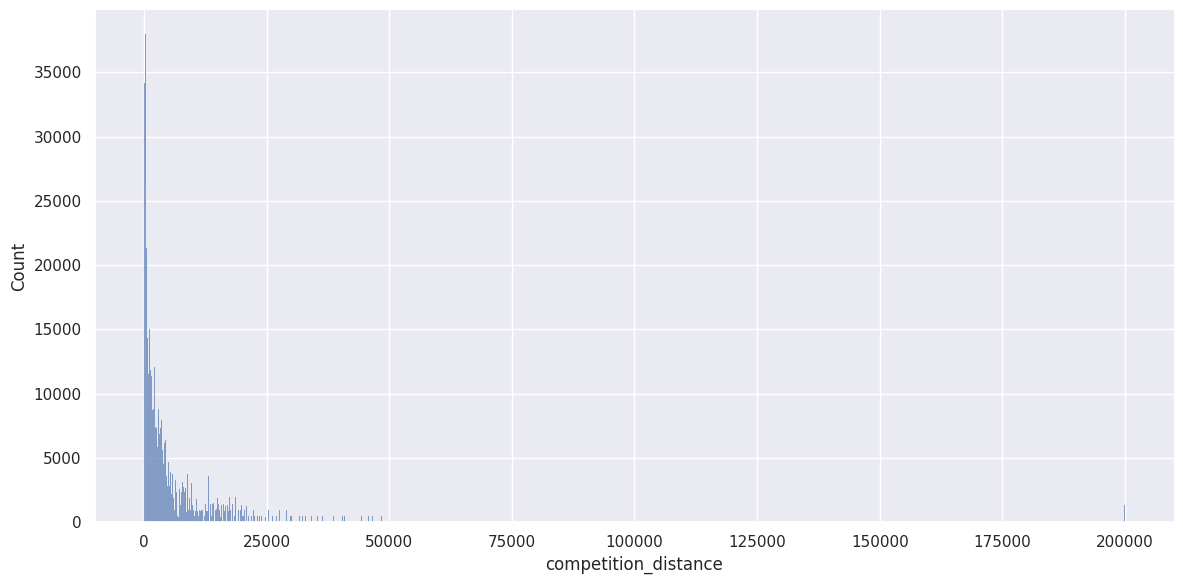

In [19]:
# Cartegorical Atributes
#sns.set(rc={'figure.figsize':(16, 6)})
sns.displot(df_renamed['competition_distance'], kde=False, height=6, aspect=2)

In [20]:
categ_attr.apply(lambda item : item.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

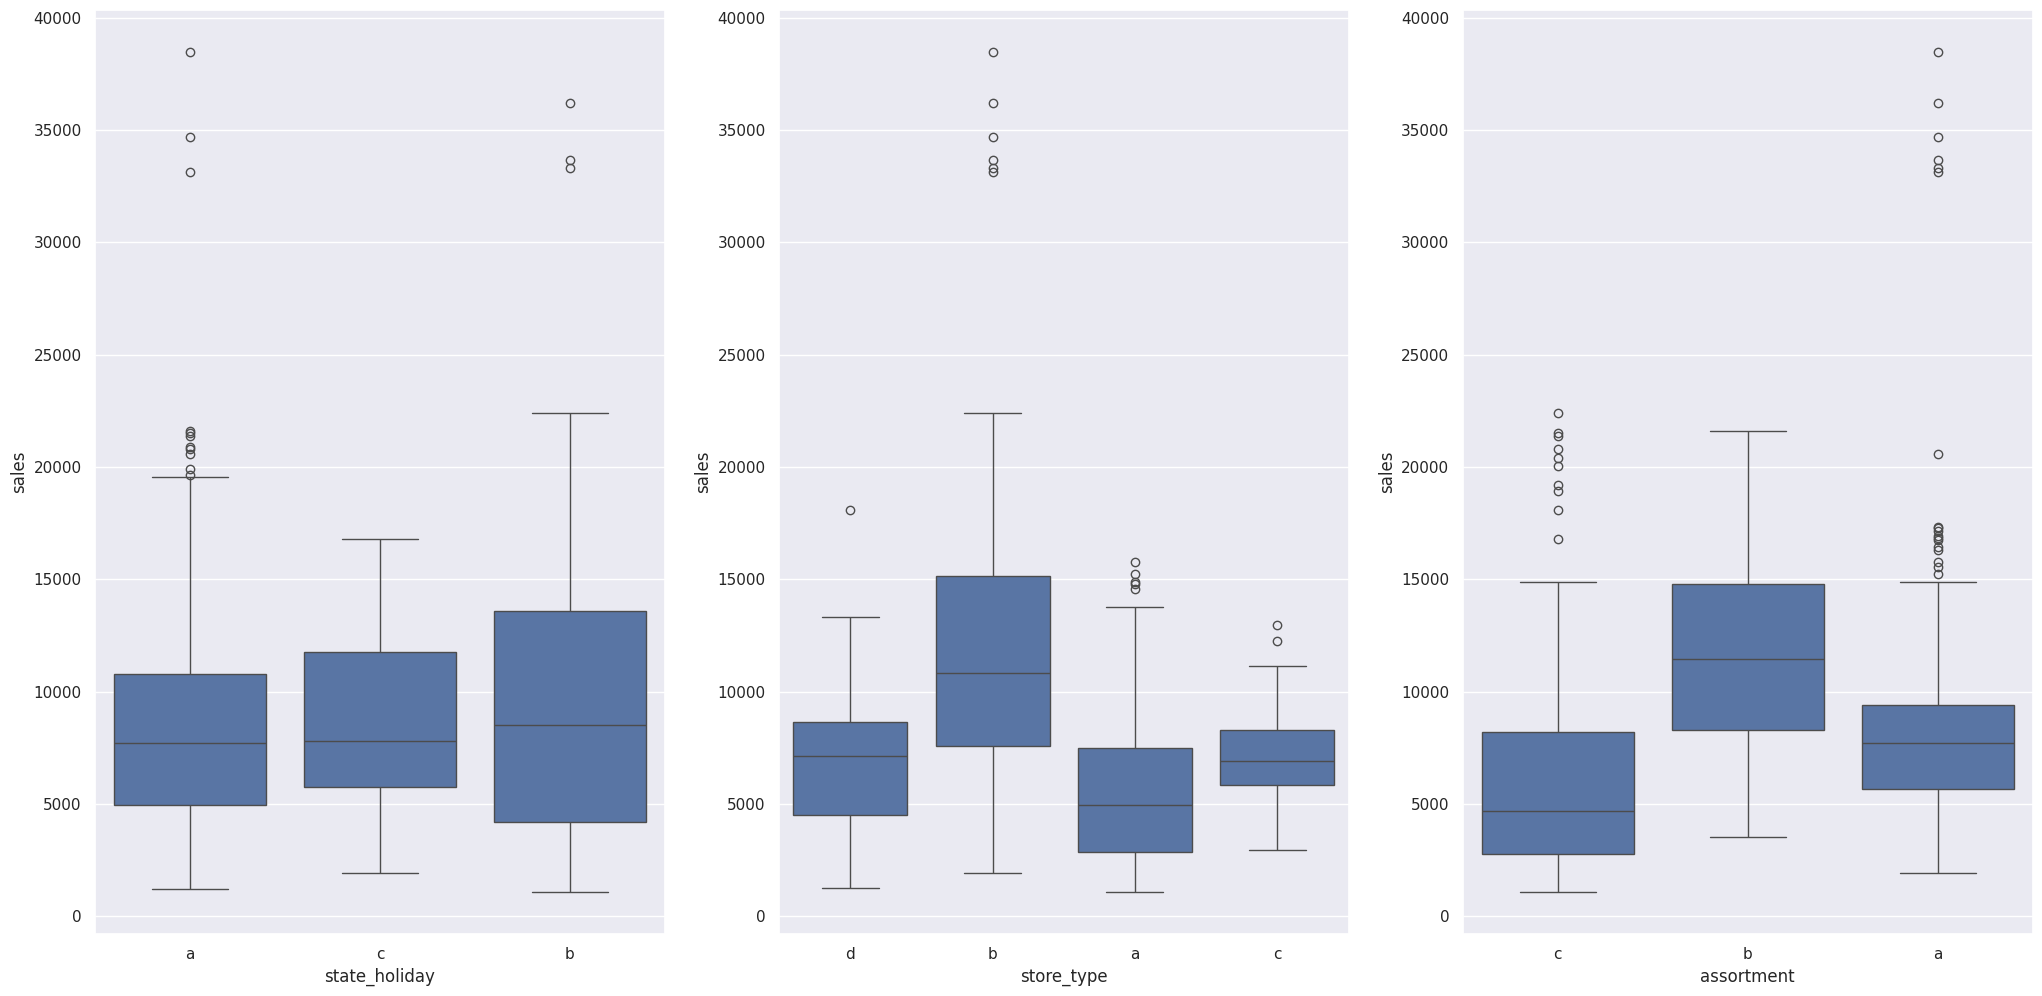

In [21]:
aux = df_renamed[(df_renamed['state_holiday'] != '0') & (df_renamed['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 Passo 2 - Feature Engineering

In [22]:
df2 = df_renamed.copy()

## 2.1 Criação das Hipoteses

### 2.1.1 Hipoteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais

### 2.1.2 Hipoteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipoteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### 2.1.4  Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# year of year
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [24]:
# competition since
df2['competition_since'] = df2.apply(lambda item: datetime.datetime( \
    year = item['competition_open_since_year'],
    month = item['competition_open_since_month'], day = 1), axis = 1)

df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

In [25]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply( \
    lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )


In [26]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda item : 'basic' if item == 'a' else 'extra' if item == 'b' else 'extend')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( \
    lambda item : 'public_holiday' if item == 'a' else 'easter_holiday' if item == 'b' else 'christmas' if item == 'c' else 'regular_day')


# 3.0 - Filtragem de variáveis

In [27]:
df3 = df2.copy()

# Filtragem das linhas
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

# Seleção das colunas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 - Análise Exploratória dos dados

In [28]:
df4 = df3.copy()

## 4.1 - Análise Univariada

<Axes: xlabel='sales', ylabel='Count'>

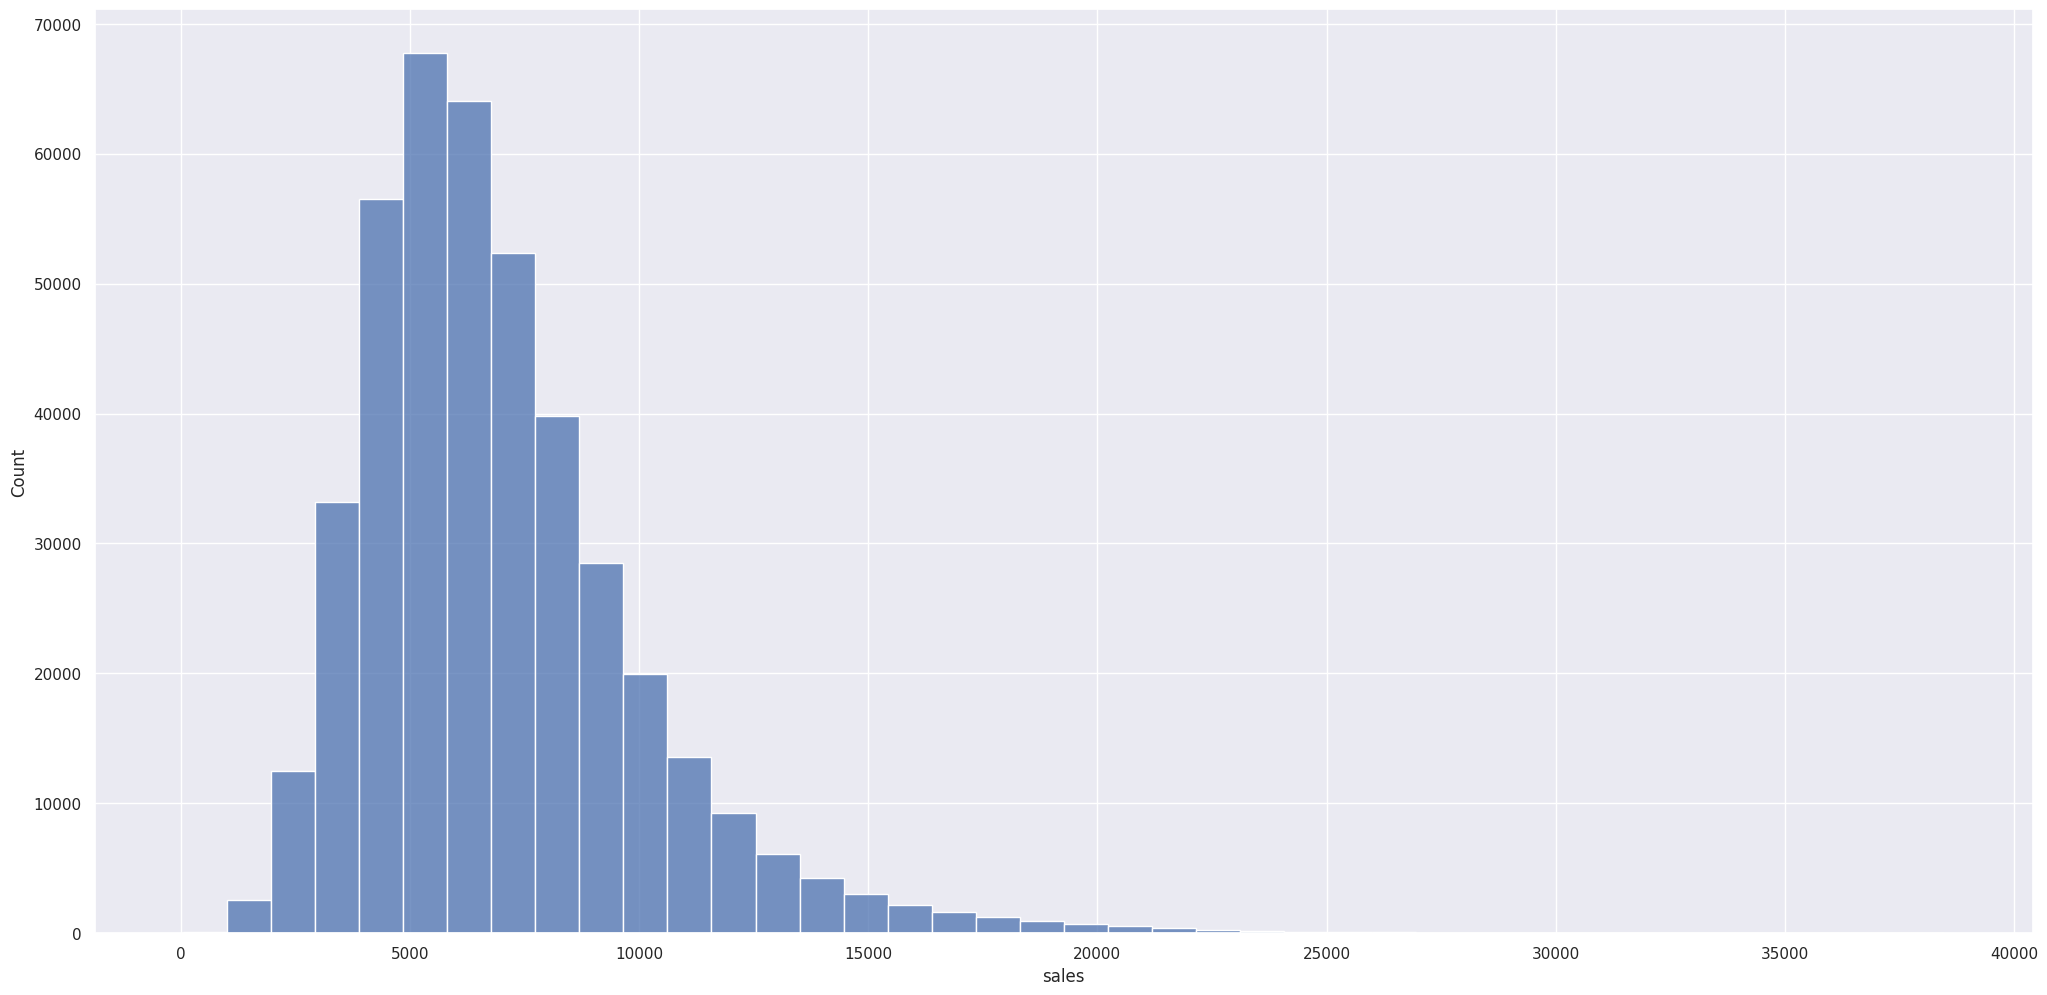

In [29]:
# Variavel Resposta

sns.histplot(df4['sales'], bins=40)

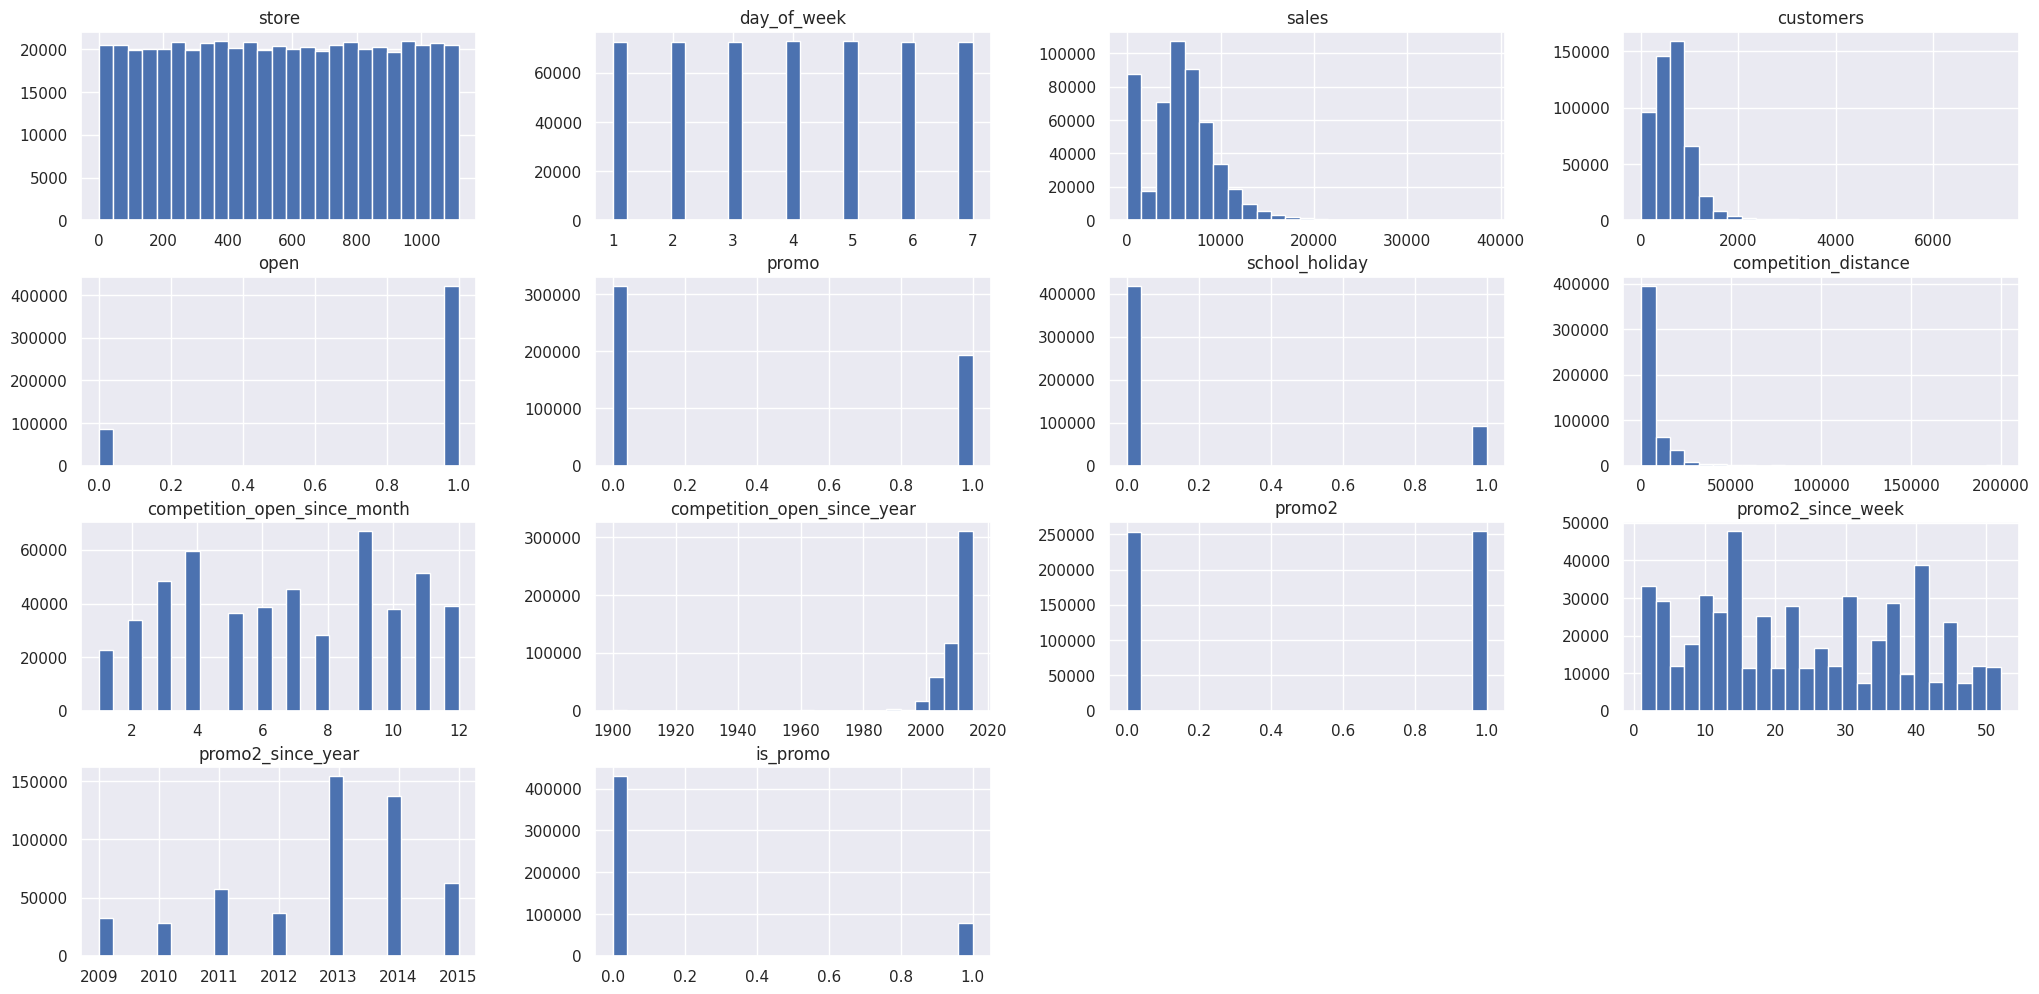

In [30]:
# Variaveis numéricas

num_attr.hist(bins=25);

<Axes: xlabel='sales', ylabel='Density'>

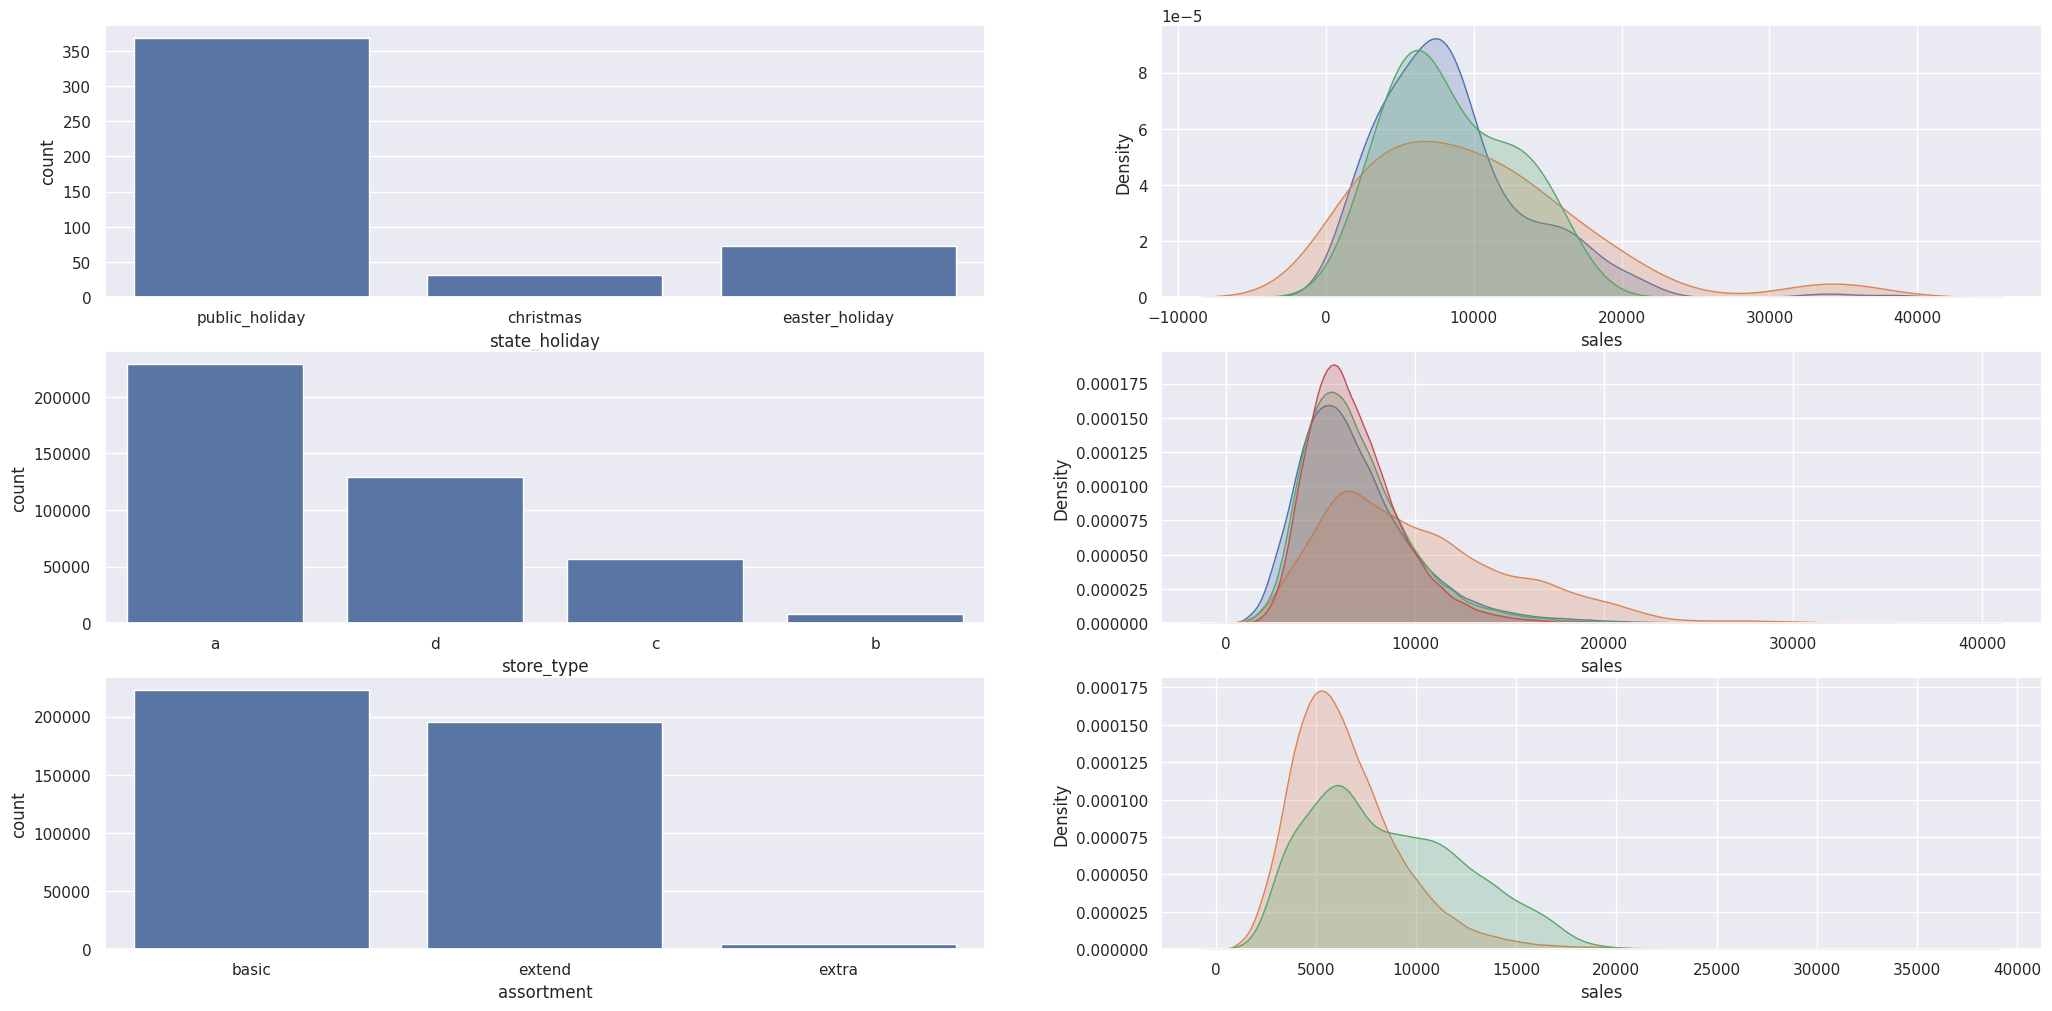

In [31]:
# Variaveis Categoricas

# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'] )
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot(x=df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x=df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )


## 4.2 - Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

**Falso**, lojas com maior sortimento vendem <b>menos</b>

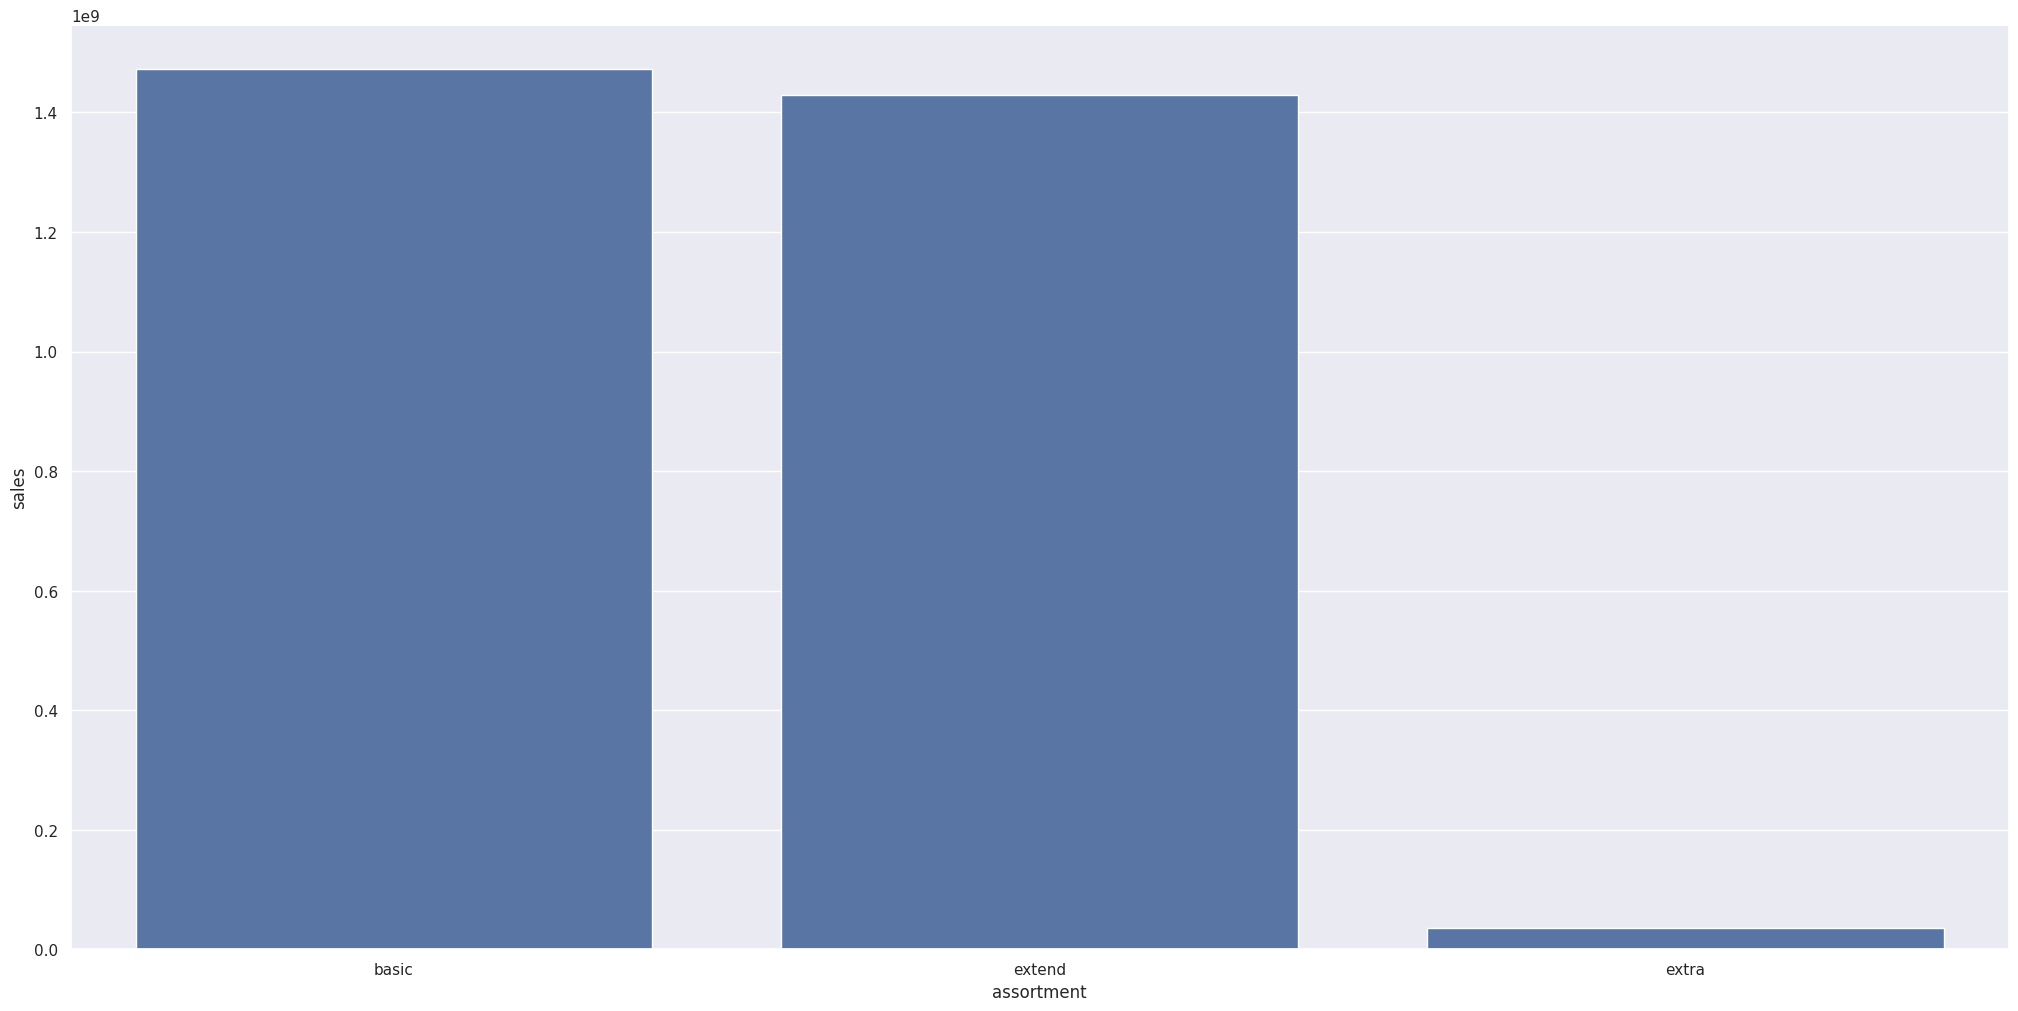

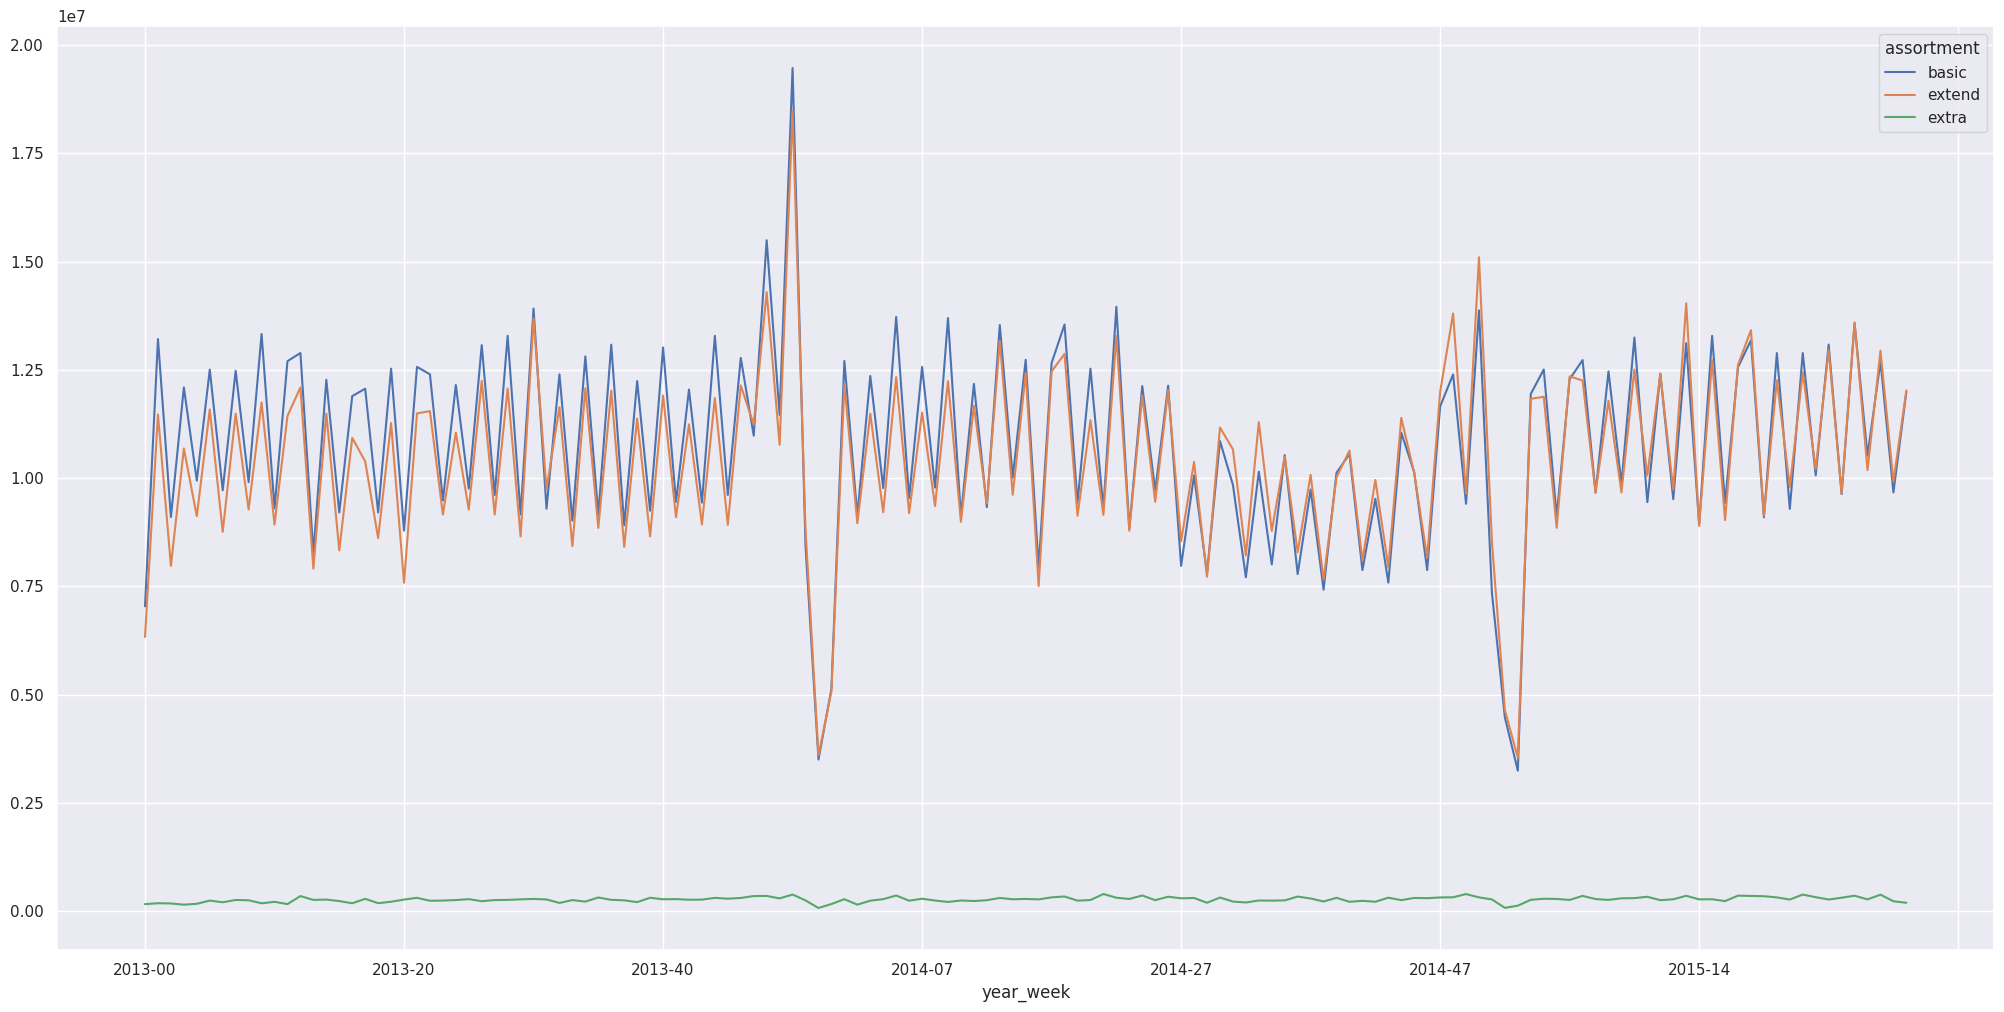

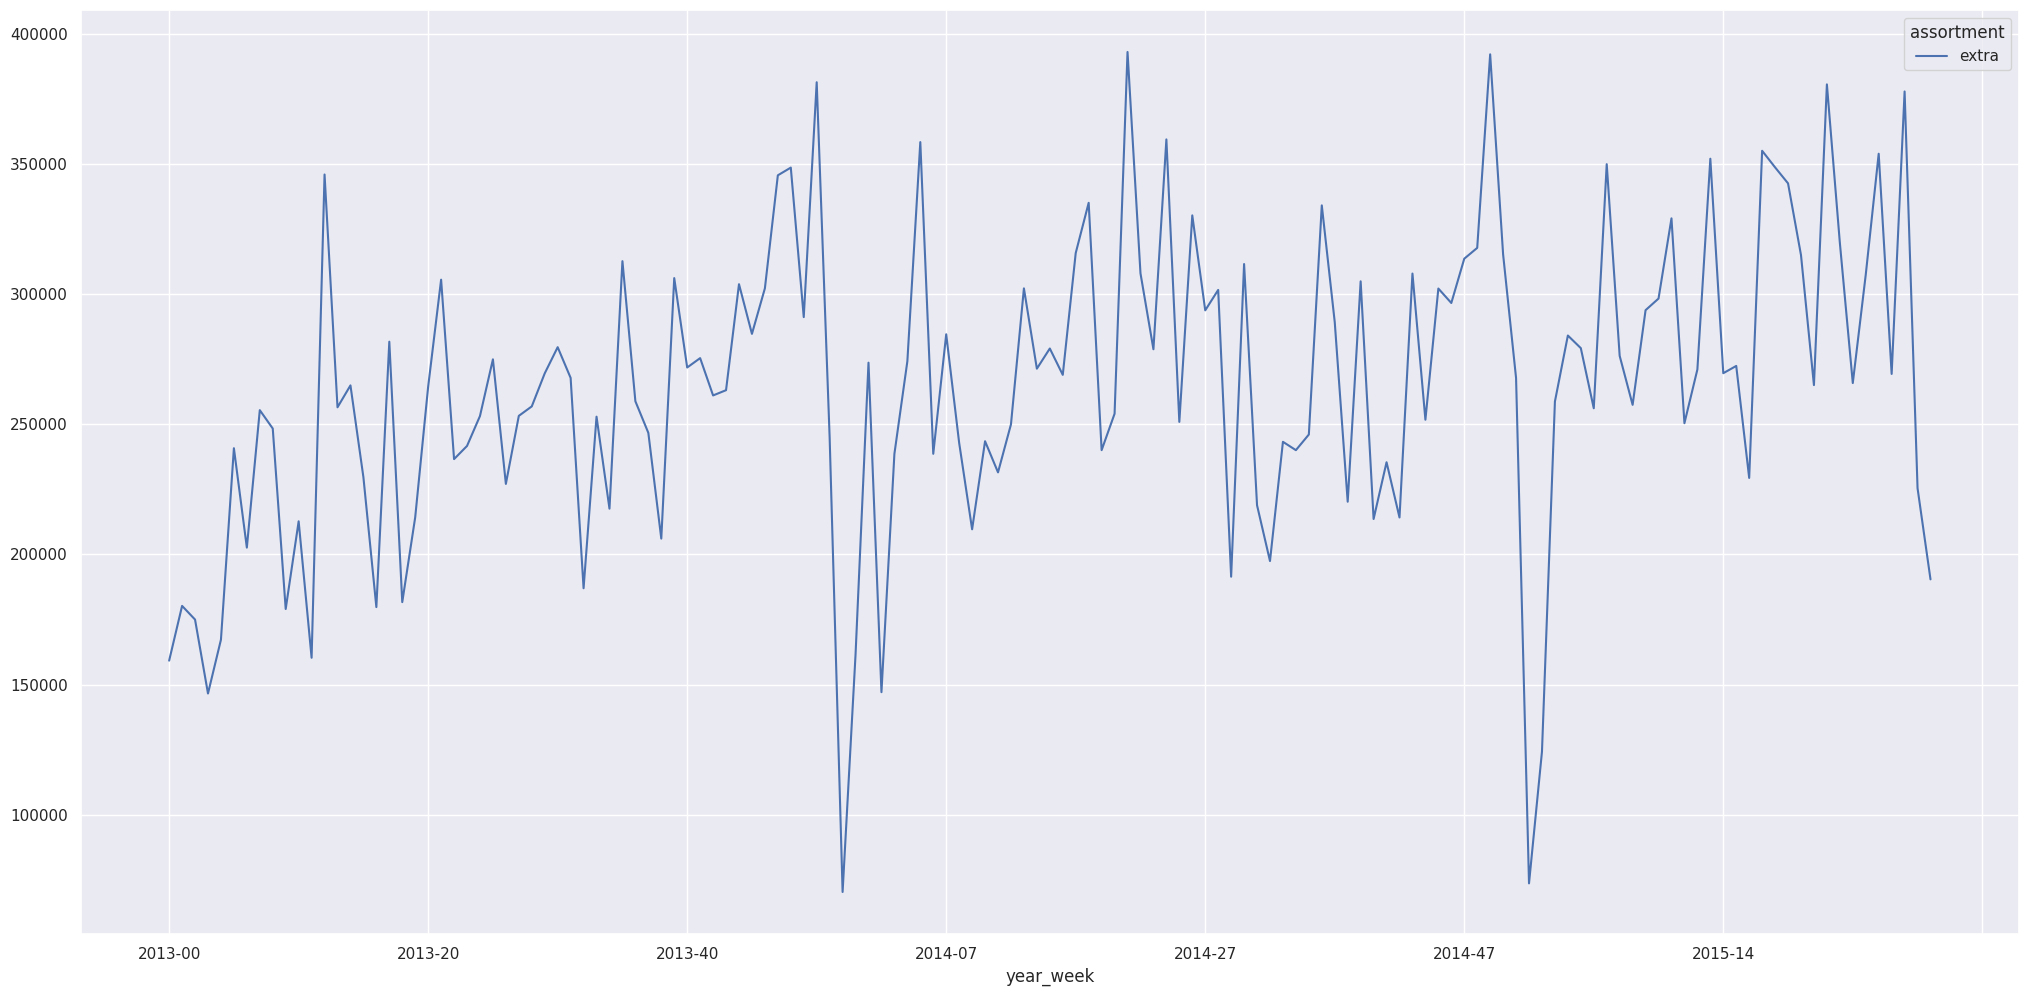

In [32]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()

sns.barplot( x='assortment', y='sales', data=aux1 );
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2. Lojas com competidores mais próximos deveriam vender menos.

FALSA Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

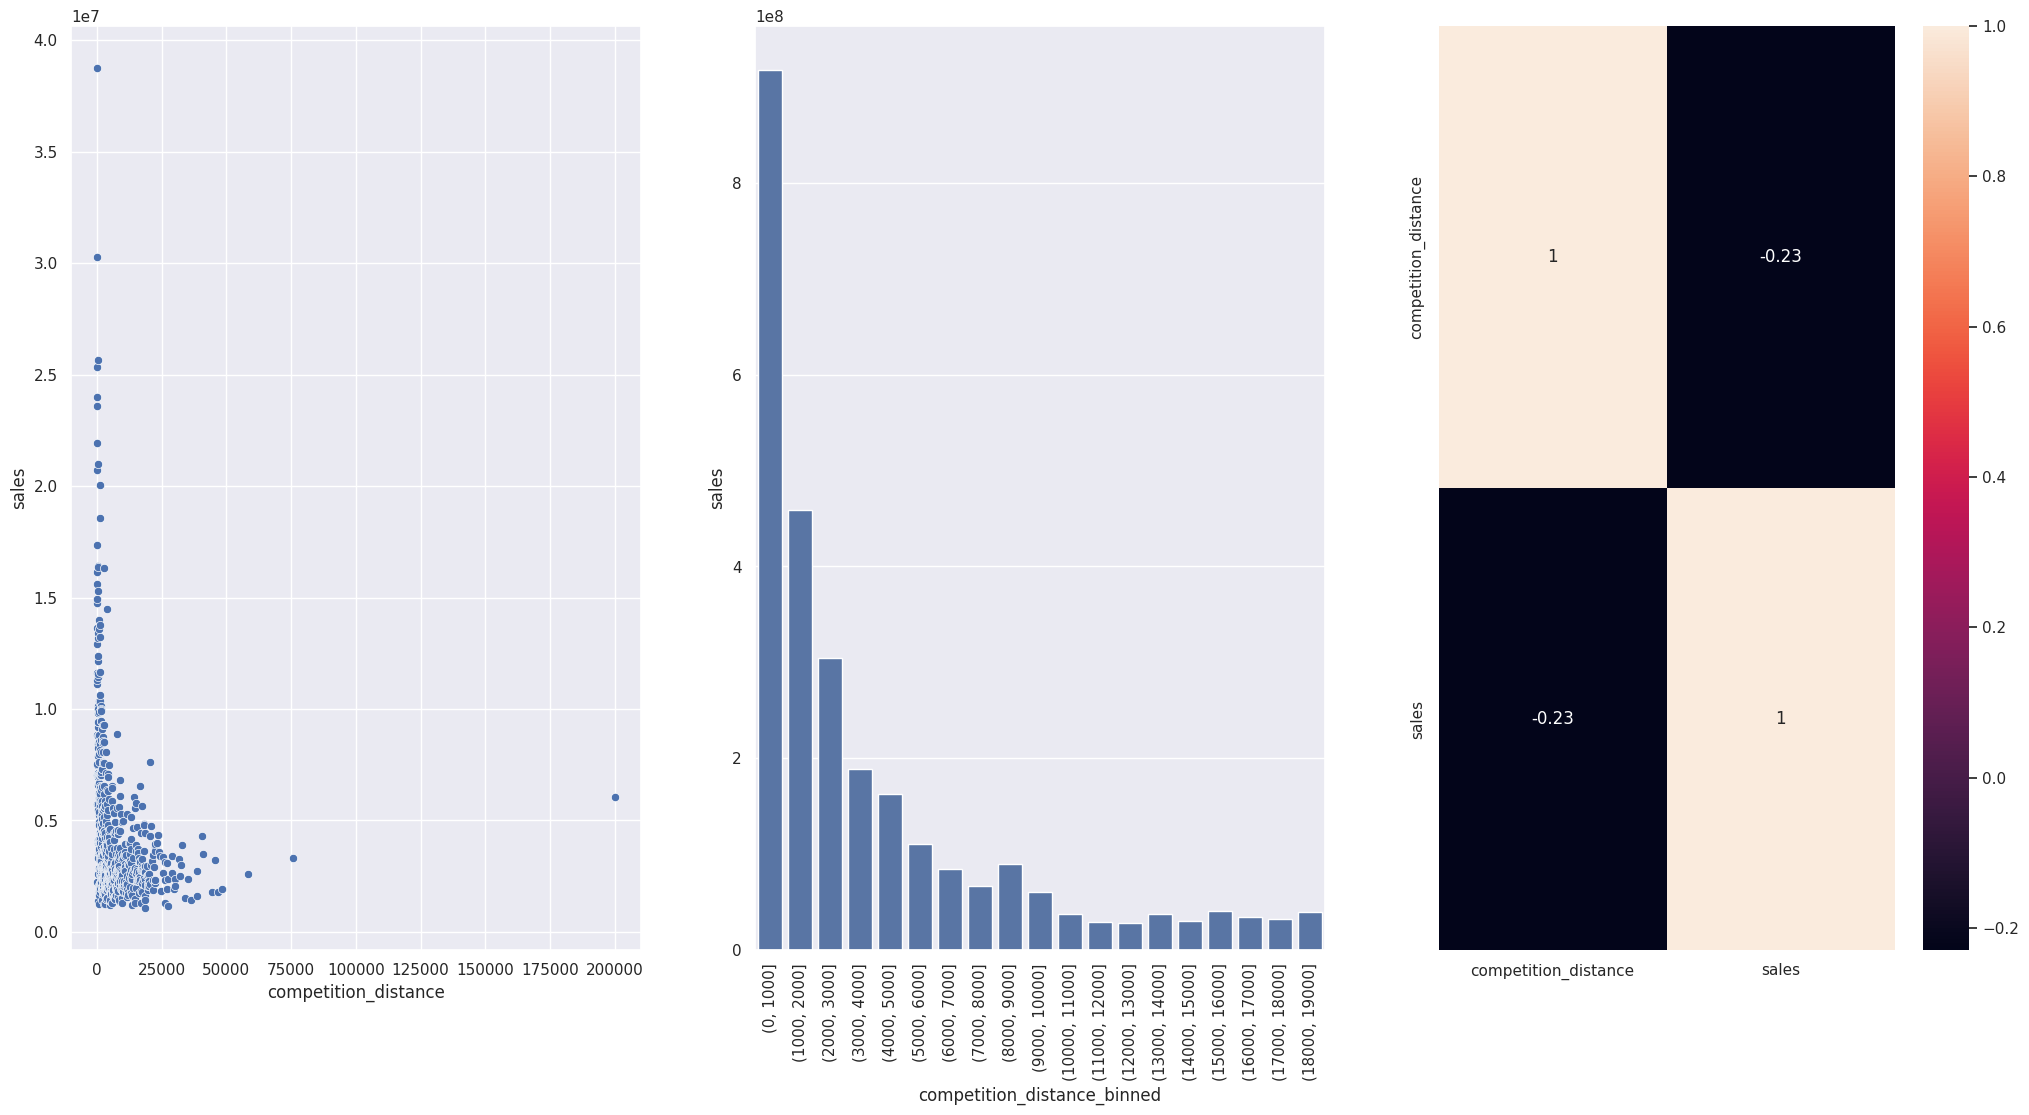

In [33]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson', numeric_only = True ), annot=True );


### H3. Lojas com competidores à mais tempo deveriam vendem mais.

FALSA Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

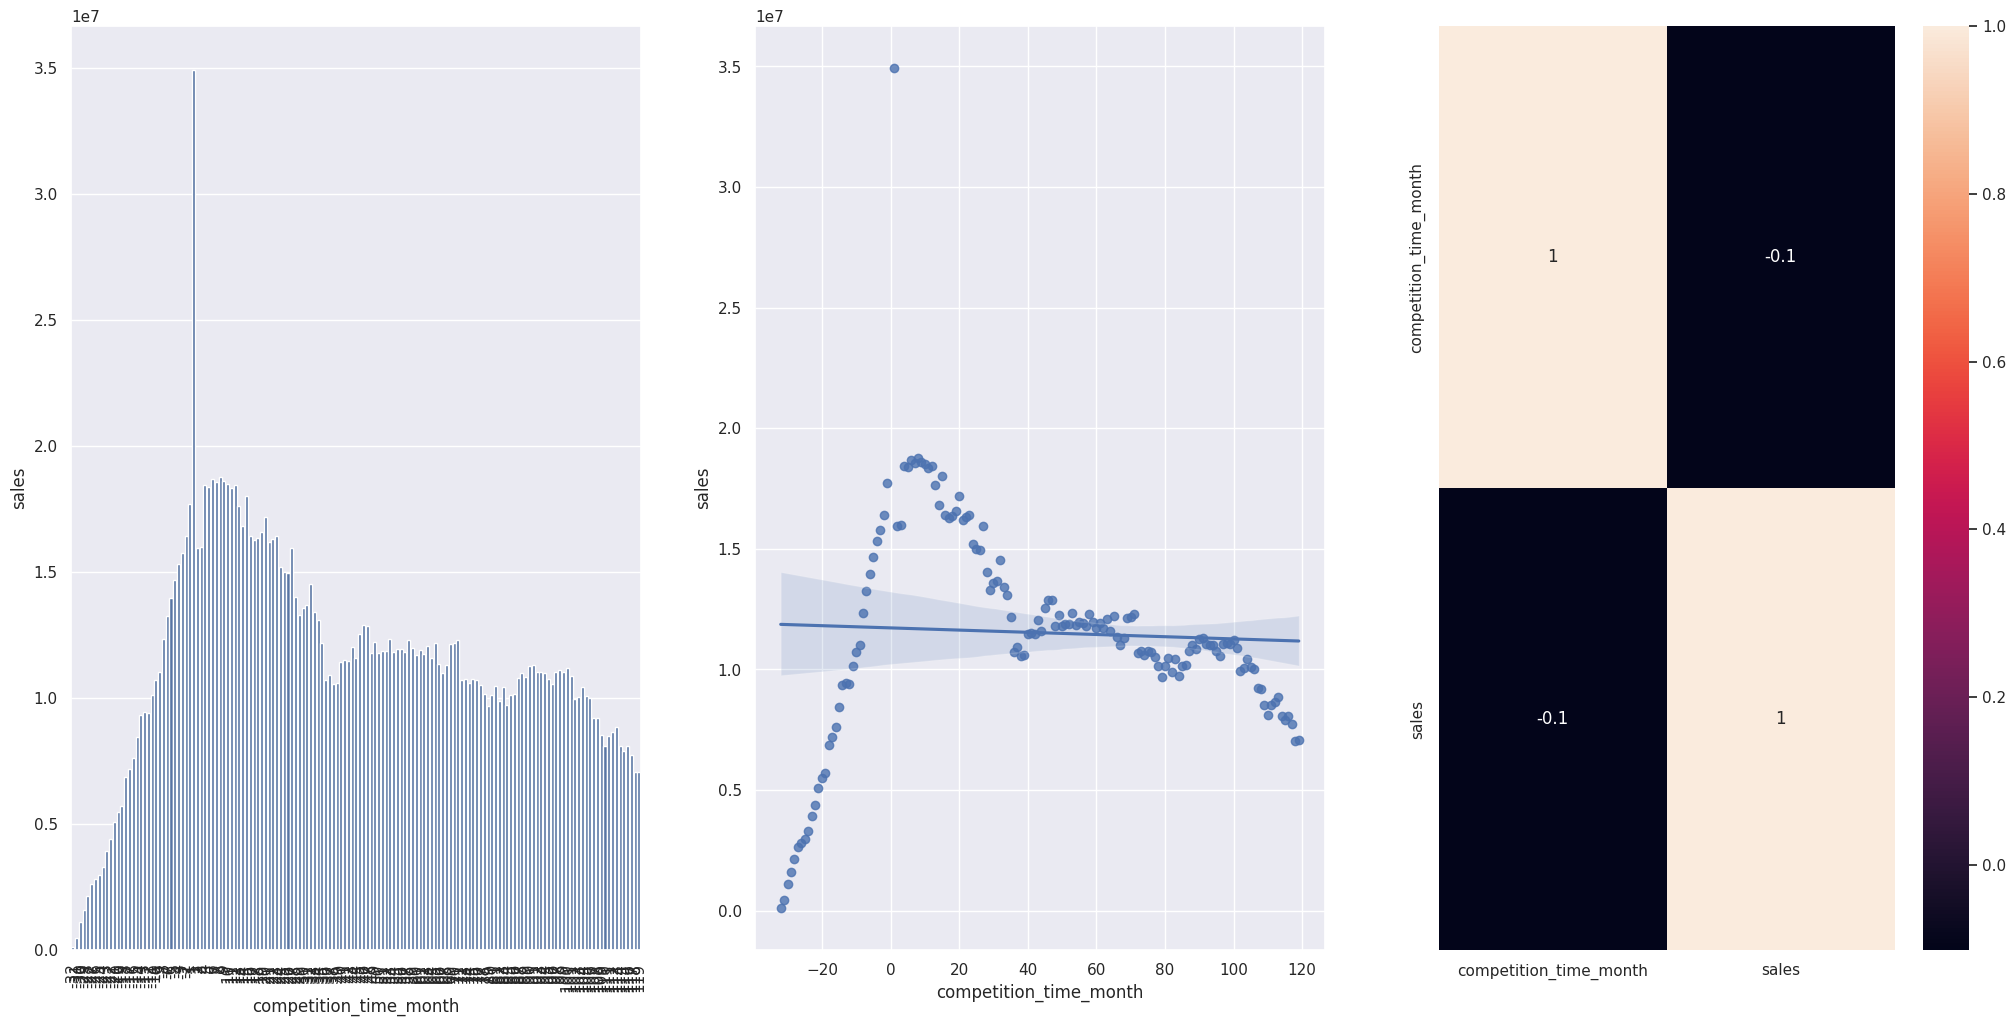

In [34]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson', numeric_only = True), annot=True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

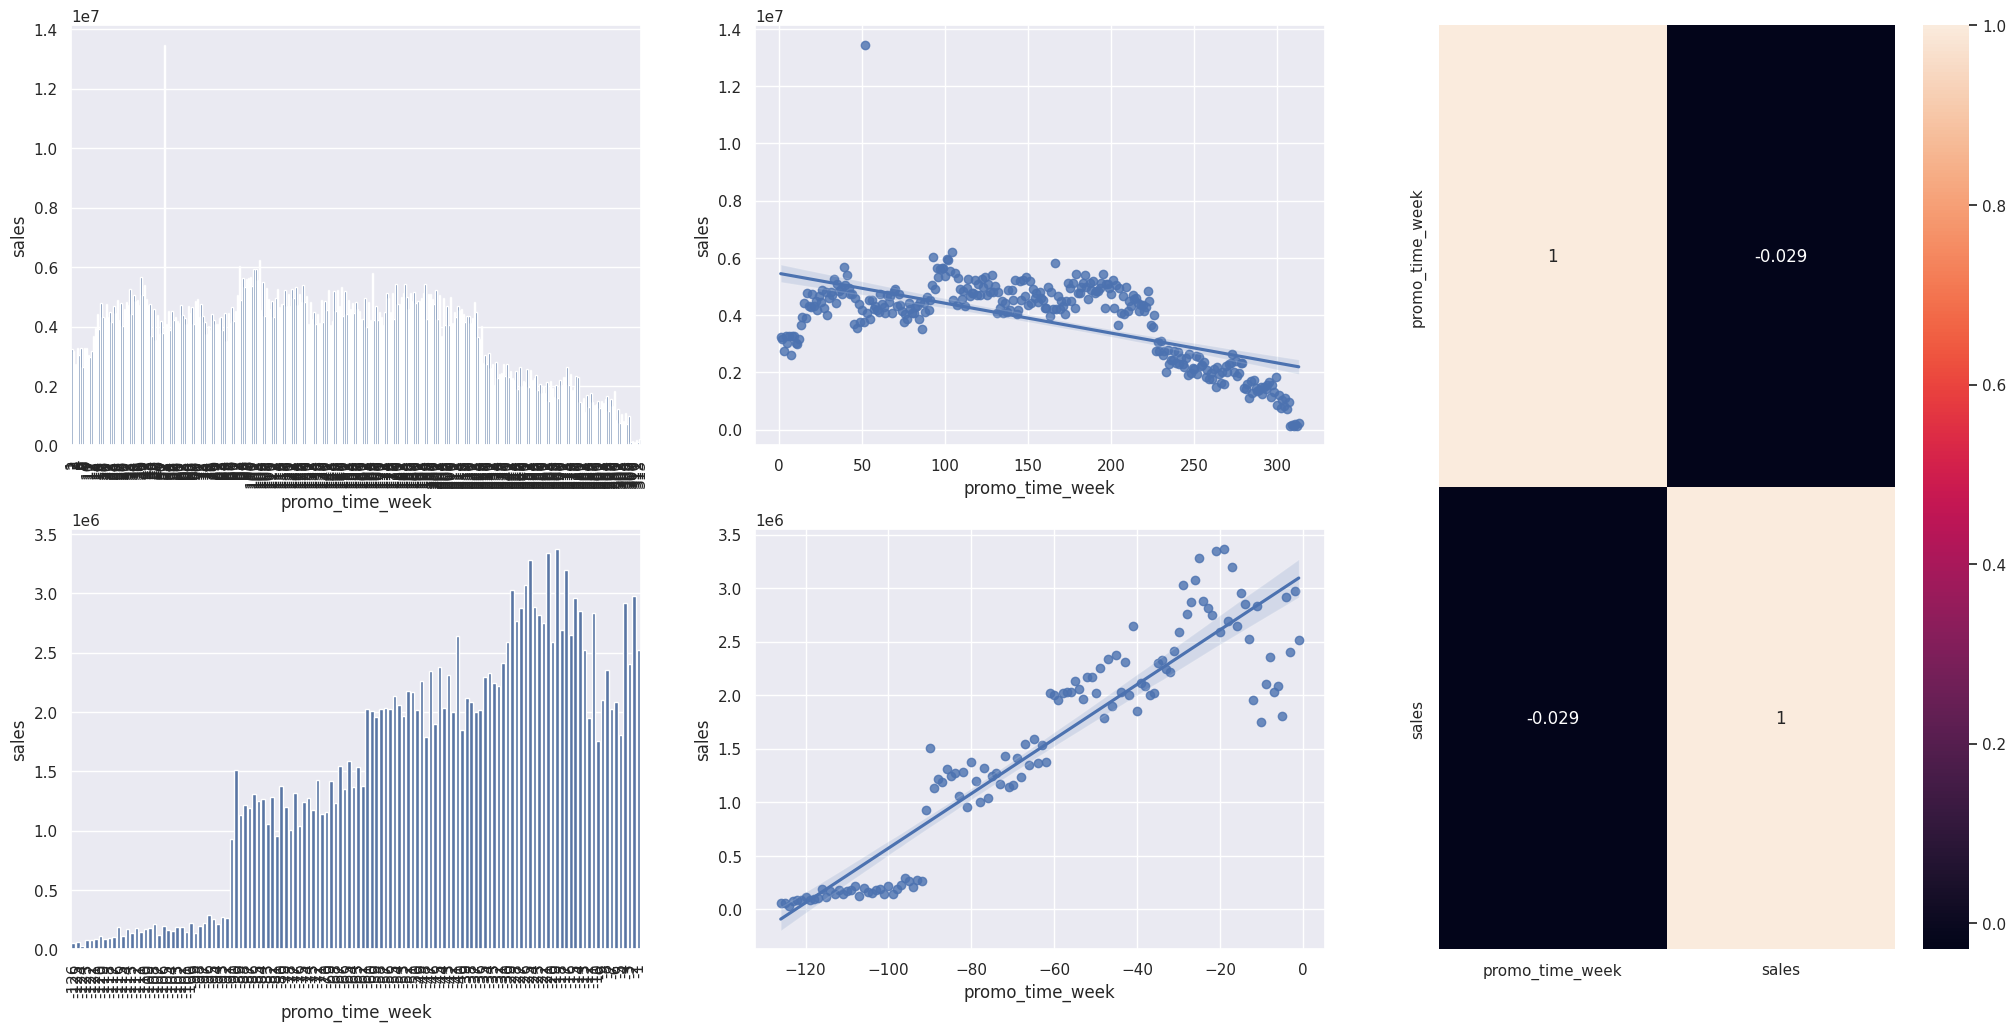

In [35]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );

plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson', numeric_only = True ), annot=True );

### H7. Lojas com mais promoções consecutivas deveriam vender mais.

FALSA Lojas com mais promocoes consecutivas vendem menos

In [36]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,742777715
1,0,1,643976288
2,1,0,813666529
3,1,1,736385833


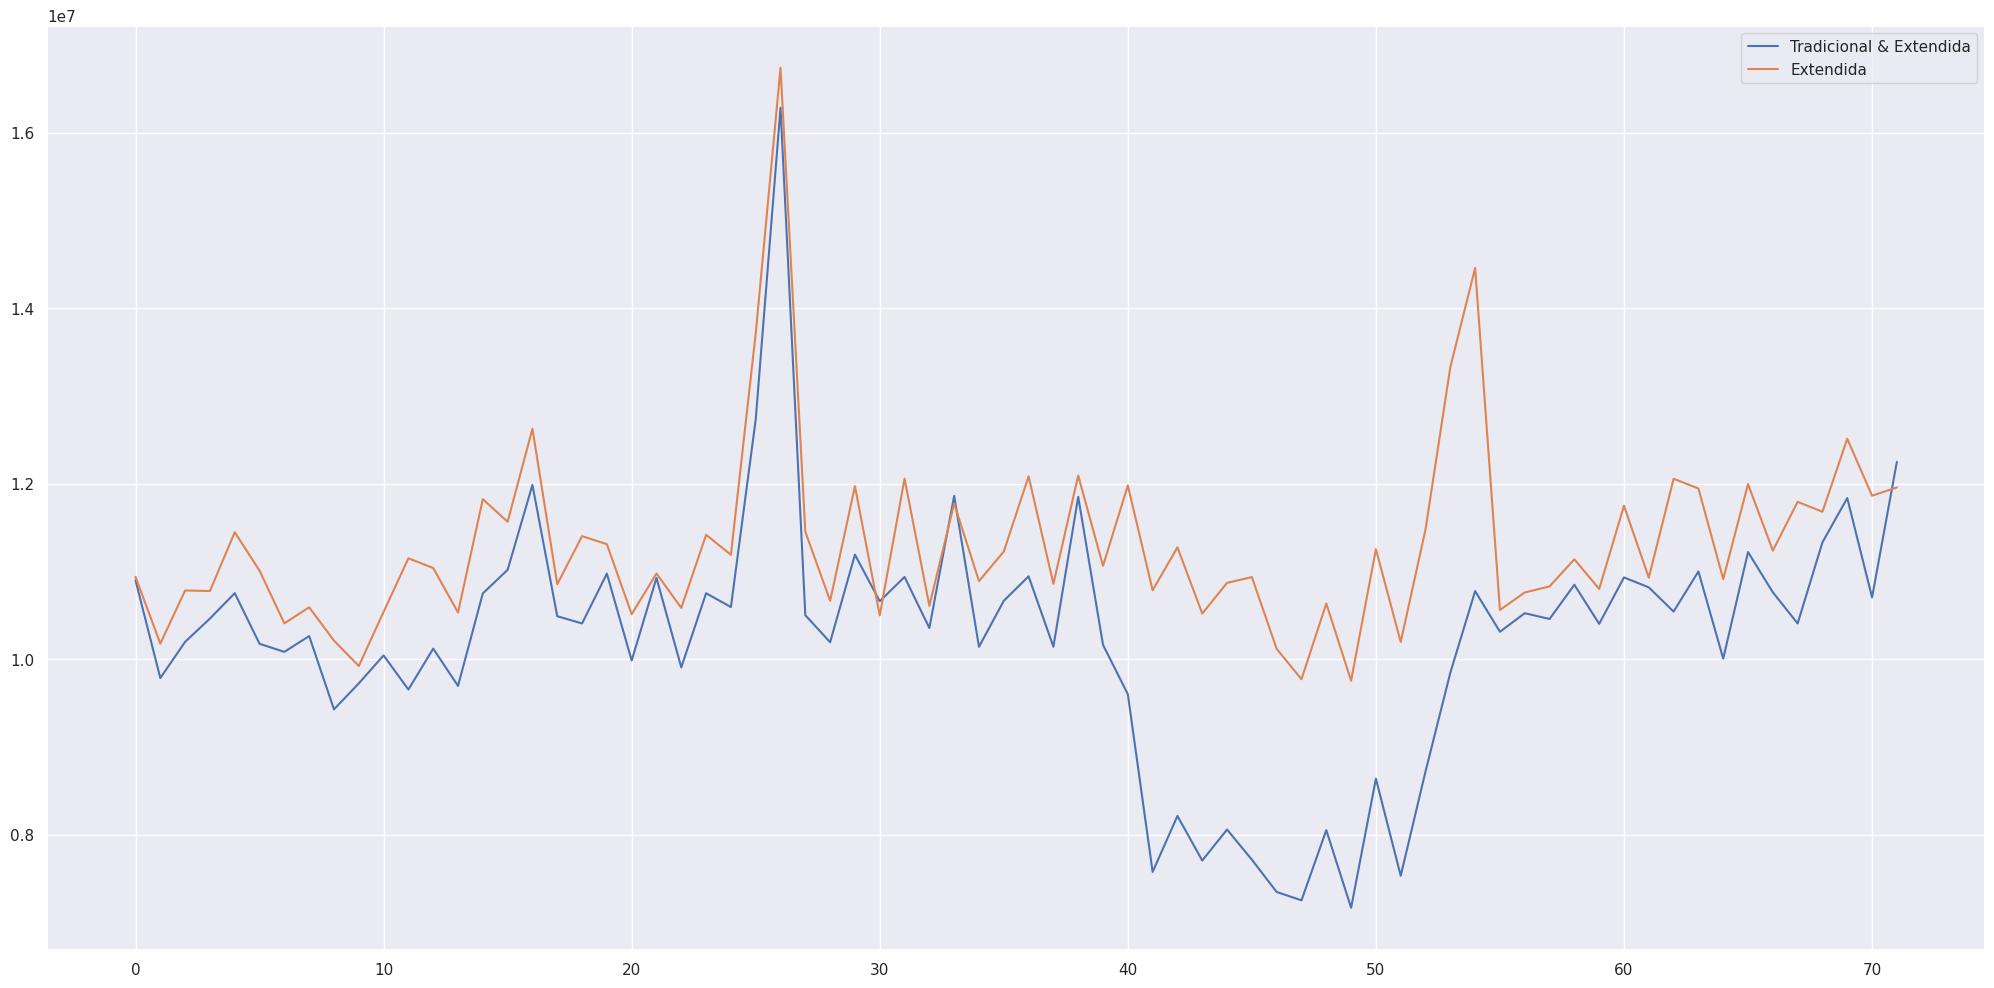

In [37]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.

FALSA Lojas abertas durante o feriado do Natal vendem menos.


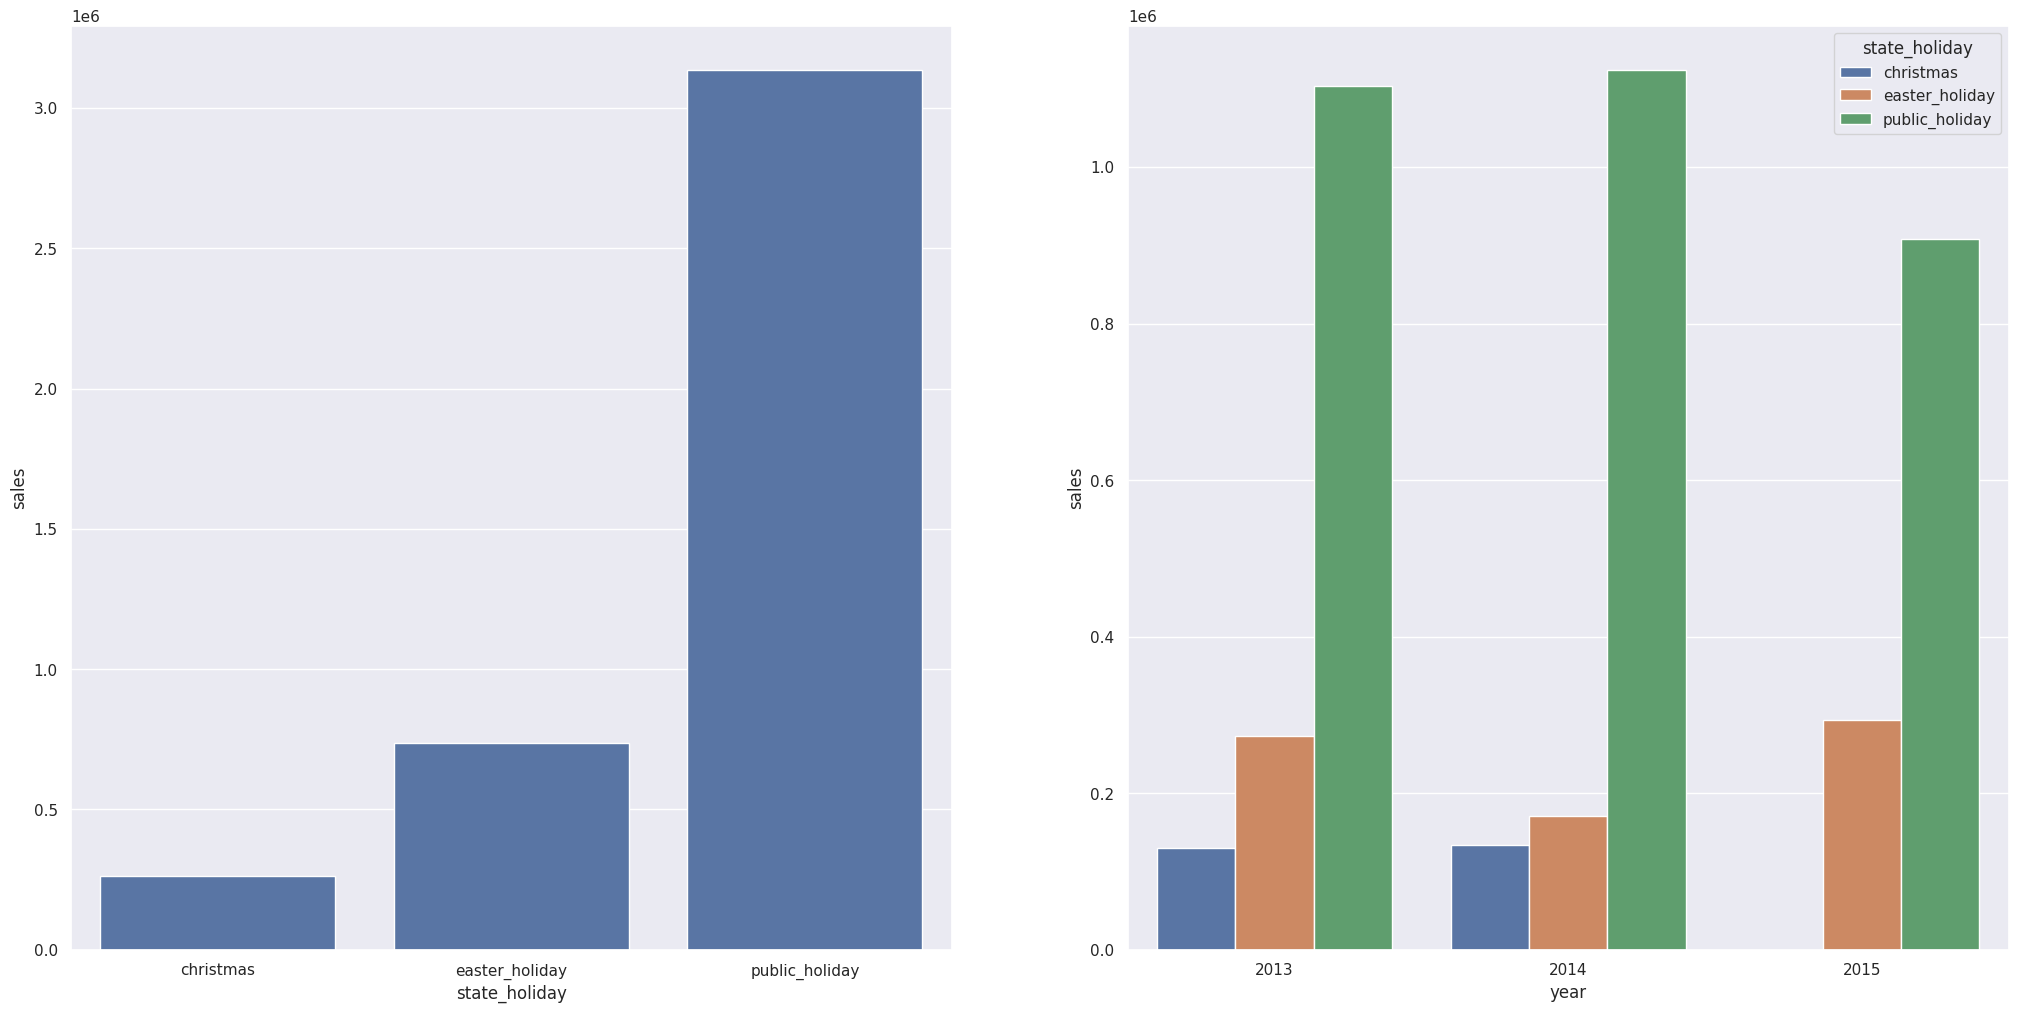

In [38]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### H9. Lojas deveriam vender mais ao longo dos anos.

FALSA Lojas vendem menos ao longo dos anos

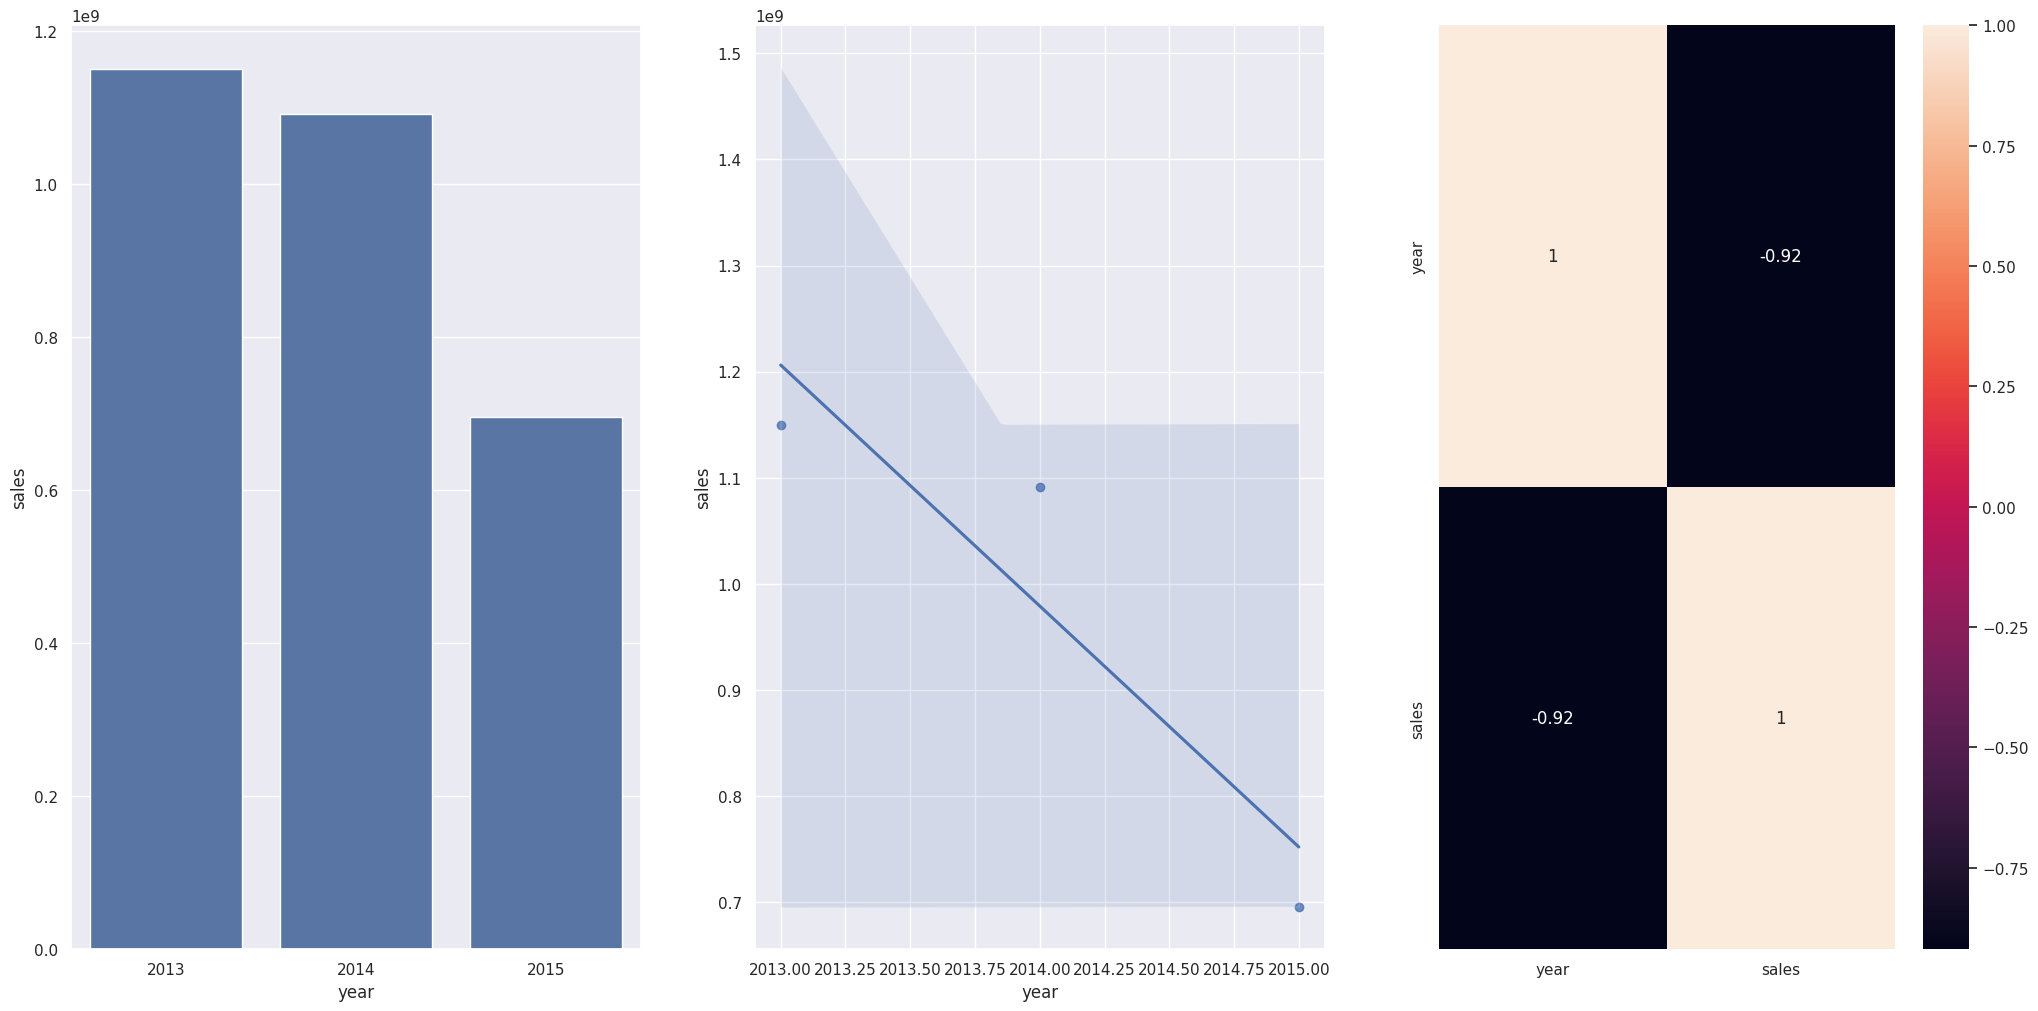

In [39]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Lojas deveriam vender mais no segundo semestre do ano.
FALSA Lojas vendem menos no segundo semestre do ano

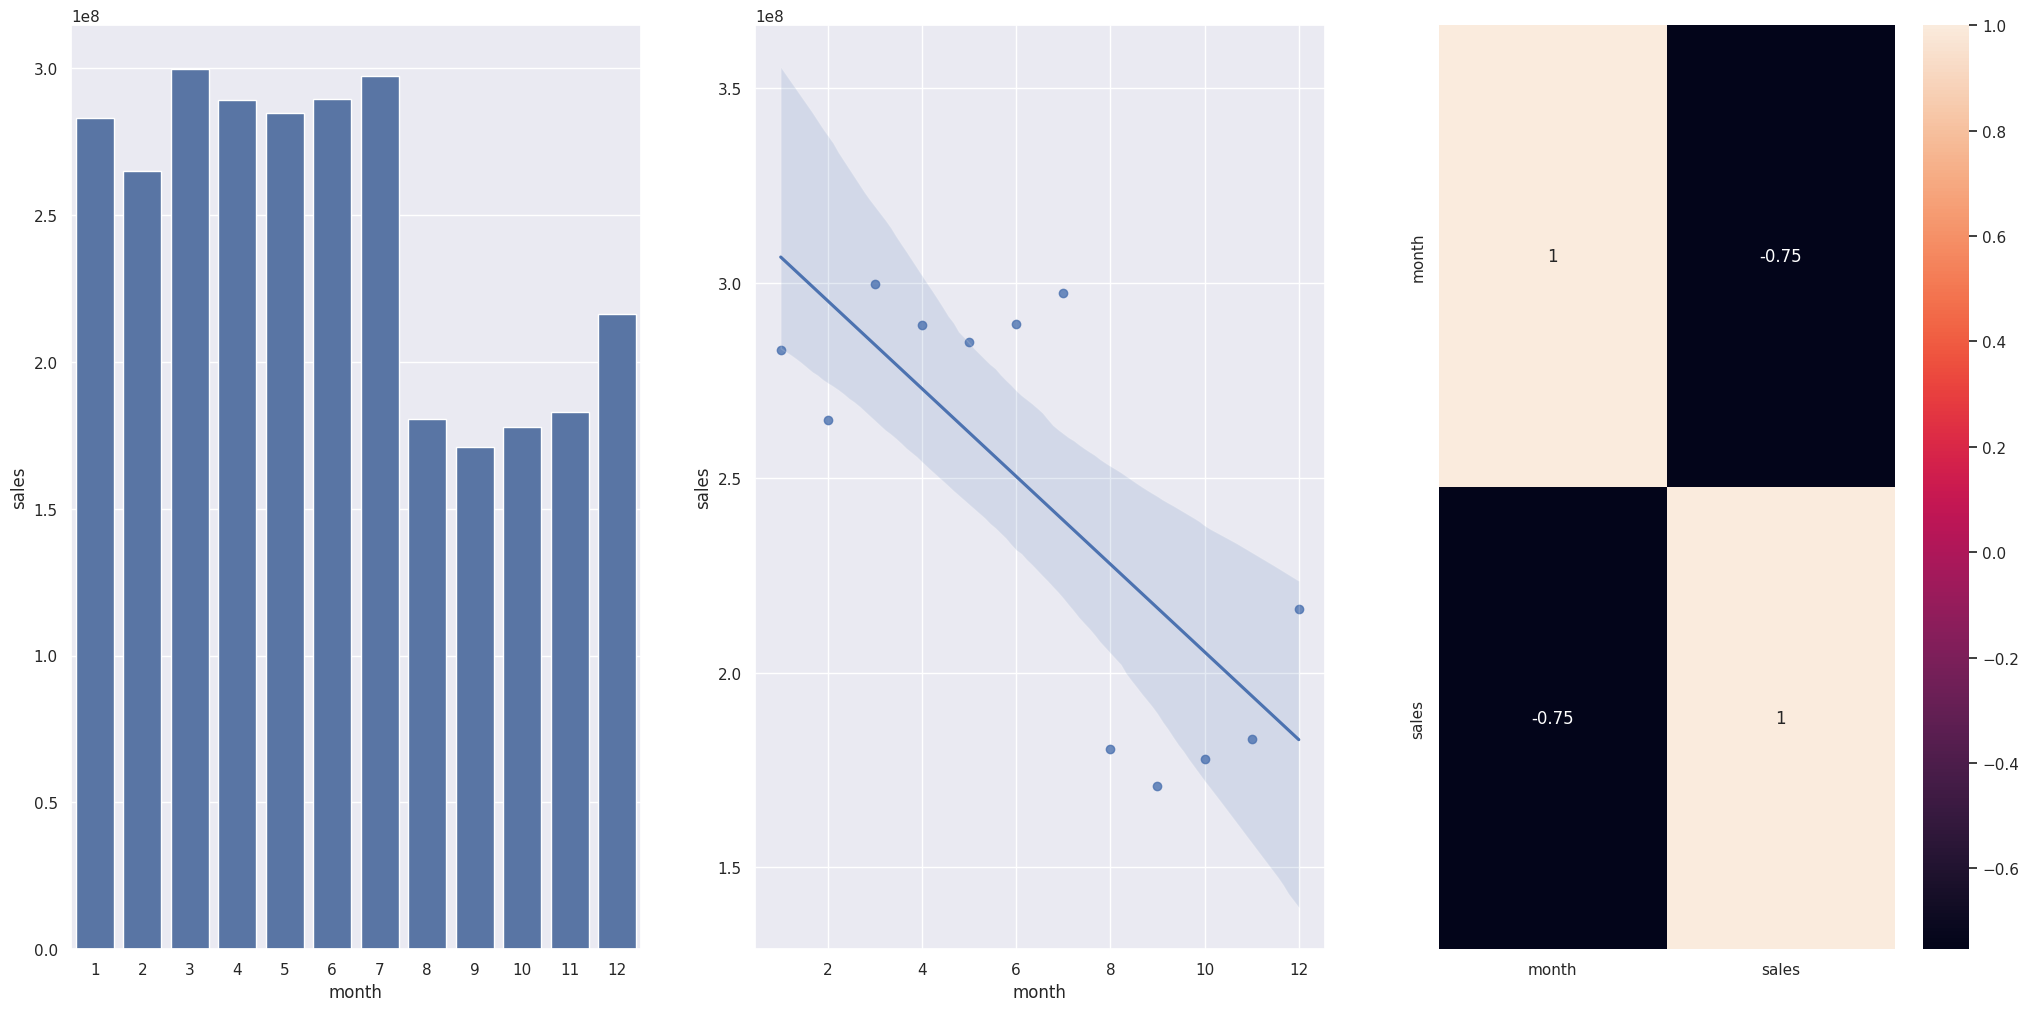

In [40]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H12. Lojas deveriam vender menos aos finais de semana.
VERDADEIRA Lojas vendem menos nos final de semana

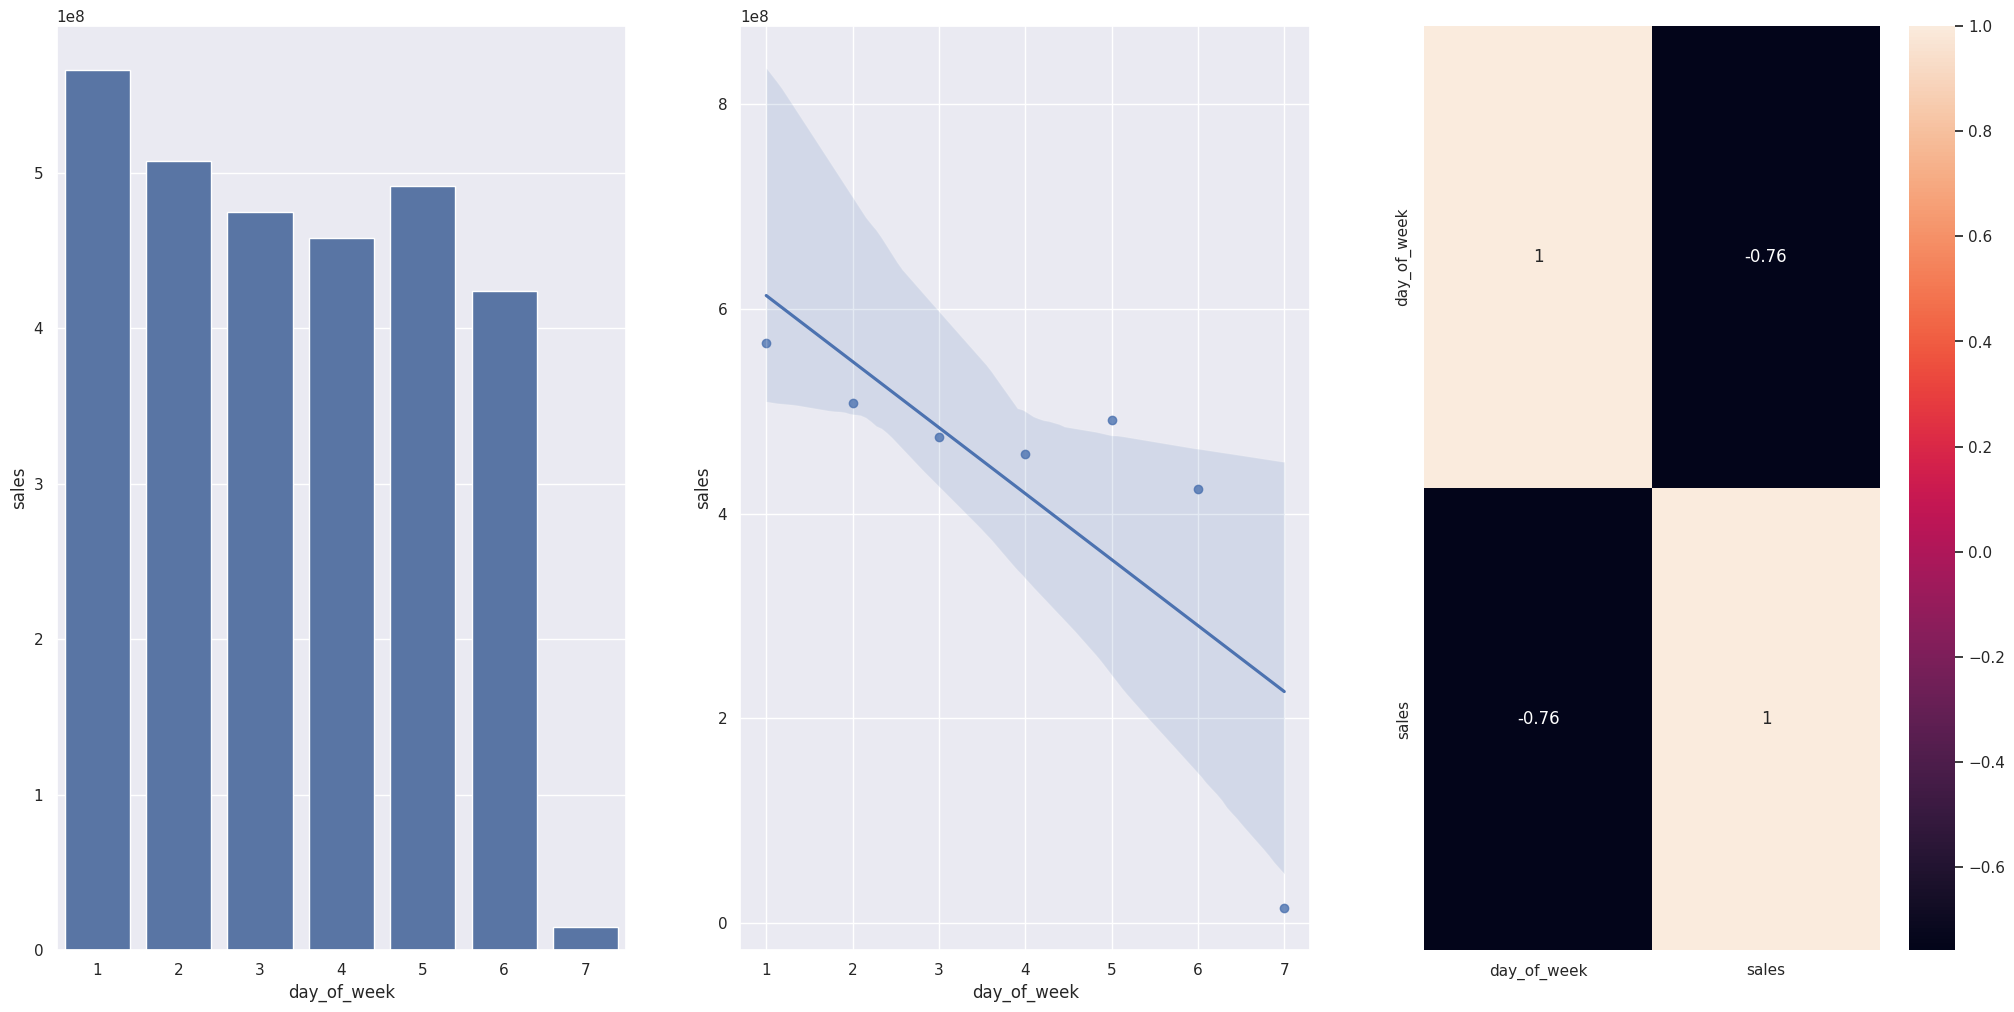

In [41]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H13. Lojas deveriam vender menos durante os feriados escolares.
VERDADEIRA Lojas vendem menos durante os feriadso escolares, except os meses de Julho e
Agosto.


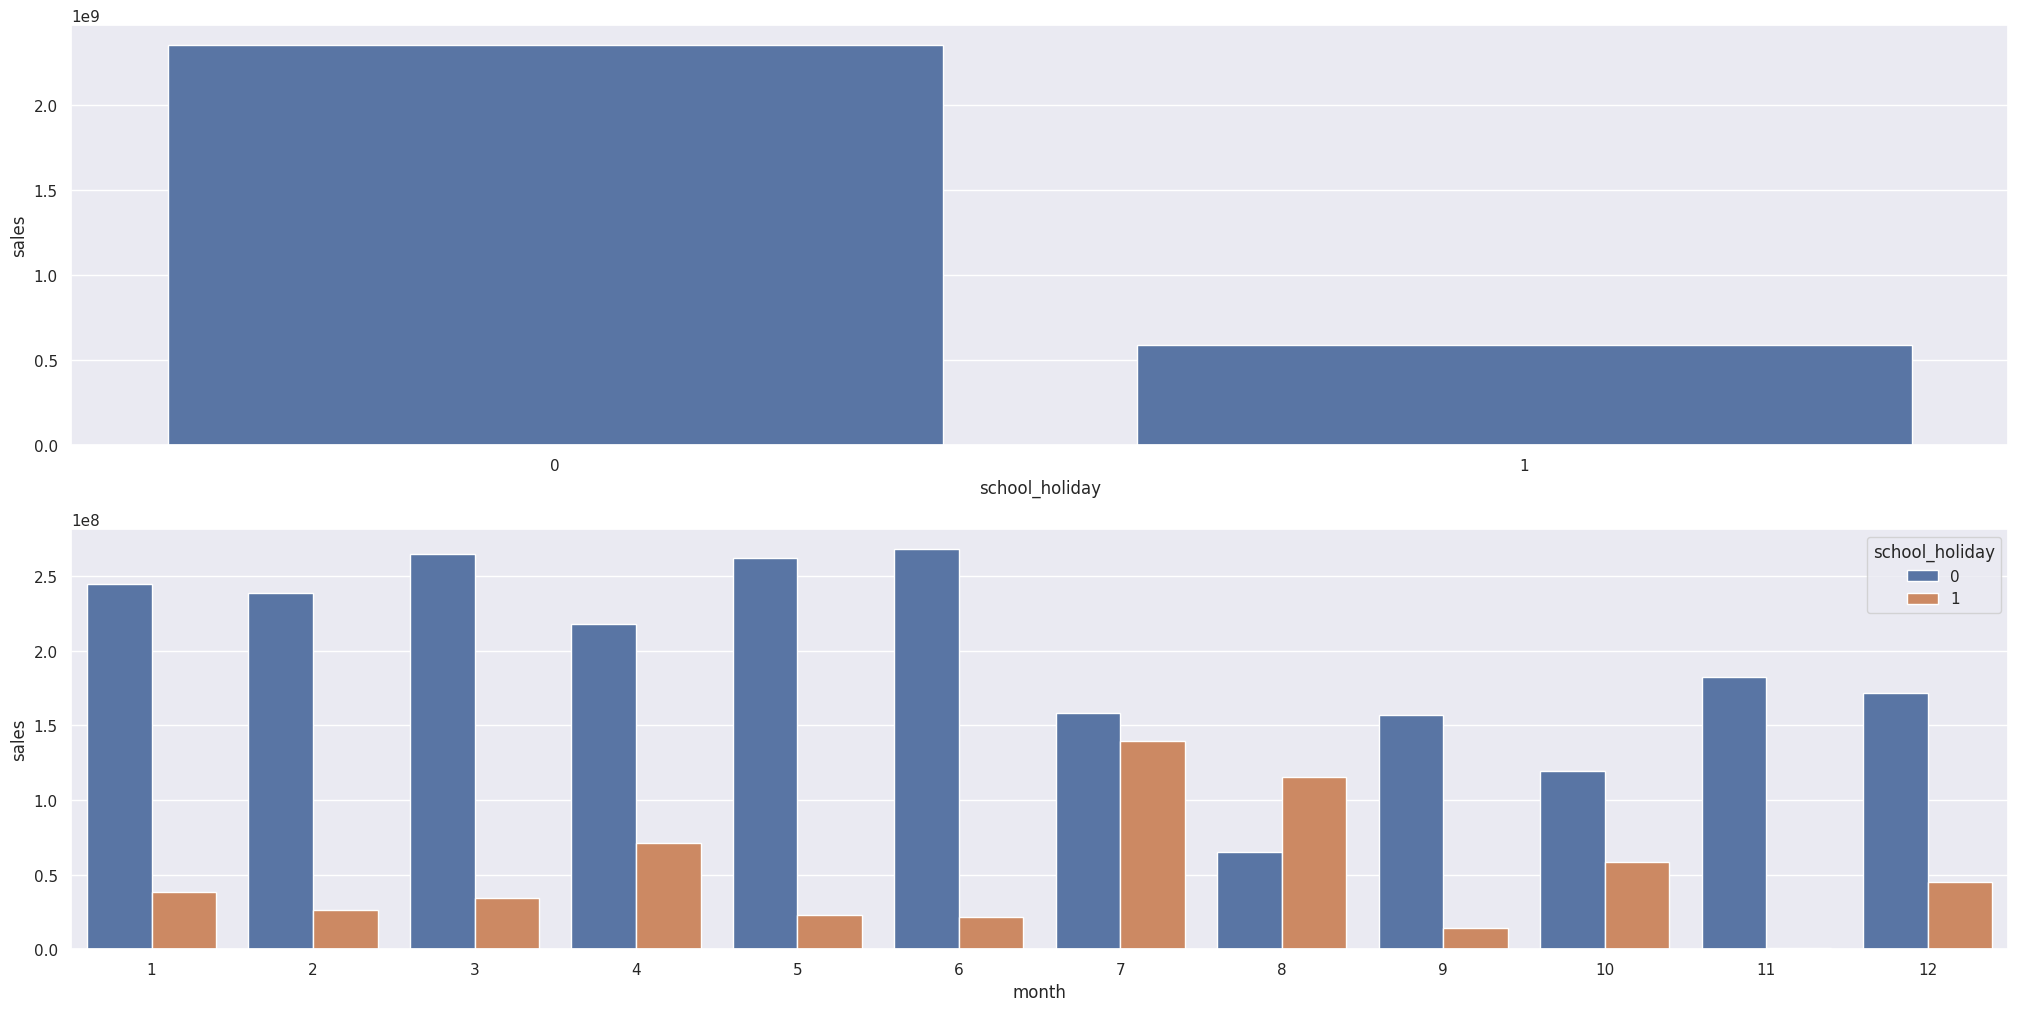

In [42]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


## 4.3 - Análise Multivariada

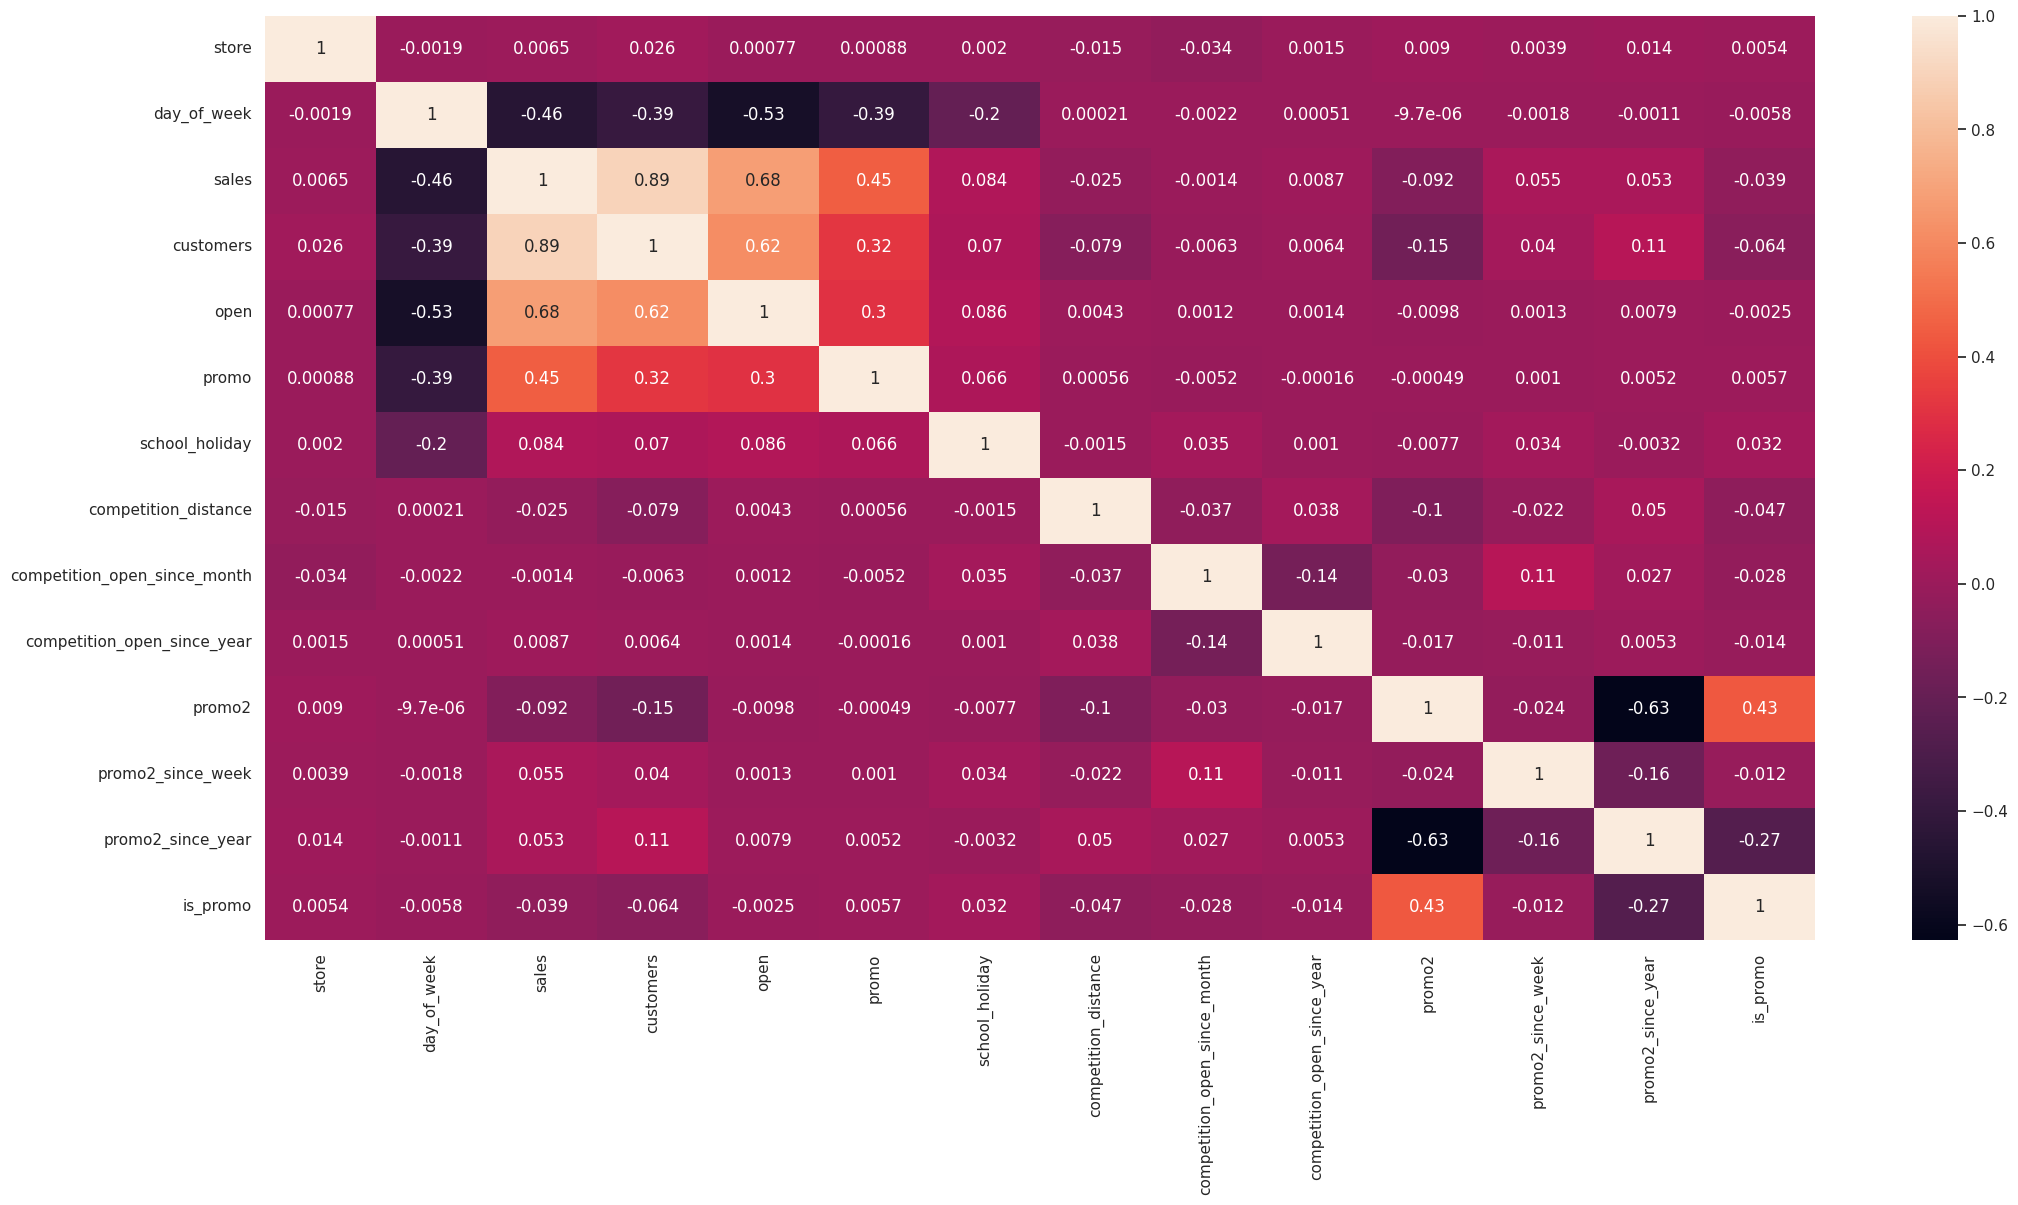

In [43]:
# Variaveis numéricas

correlation = num_attr.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 5.0 Preparação dos dados

In [95]:
df5 = df4.copy()

## 5.2 Rescaling

In [96]:
## Min-Max Scaler - sensivel a outliers
## Robust Scaler - 'resolve o problema' de sensibilidade aos outliers  

rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
# sns.boxplot(df4['competition_distance'])
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mms, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformação

### 5.3.1 Encoding

In [97]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extend': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [47]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformation

In [48]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# 6.0 Seleção de variaveis

In [49]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [50]:
cols_drop = ['day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]

df6 = df6.drop( cols_drop, axis=1 )

In [51]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [52]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1, n_estimators=20 )

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

###  6.2.1. Best Features from Boruta

In [53]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [54]:
# manual Feature Selection

cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',]

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 Machine Learning Modeling

In [55]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [56]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1319.744903,0.4363,1777.377491


## 7.2 Linear Regression

In [57]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))

lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1878.790056,0.292514,2682.704009


### 7.2.1 Linear Regression - Cross Validation

In [58]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2071.69 +/- 283.25,0.3 +/- 0.02,2936.58 +/- 448.48


## 7.3 Linear Regression Regularized Model - Lasso

In [59]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasoo', np.expm1( y_test ), np.expm1( yhat_lrr ))

lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasoo,1899.240655,0.28869,2751.827094


### 7.3.1 Lasso - Cross Validation

In [60]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )

lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2107.76 +/- 332.86,0.29 +/- 0.01,3044.6 +/- 488.92


## 7.4 Random Forest Regressor

In [61]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )

rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,710.406671,0.105524,1026.504427


### 7.4.1 Random Forest Regressor - Cross Validation

In [62]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )

rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,908.53 +/- 305.73,0.13 +/- 0.03,1351.08 +/- 458.76


## 7.5 XGBoost Regressor

In [63]:
# model
model_xgb = xgb.XGBRegressor( 
    objective='reg:squarederror',
    n_estimators=900,
    eta=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )

xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,870.449686,0.127114,1258.17997


### 7.5.1 XGBoost Regressor - Cross Validation

In [64]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )

xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1034.94 +/- 195.17,0.14 +/- 0.02,1498.61 +/- 278.65


## 7.6 Compare Model´s Performance

### 7.6.1 Single Performance

In [65]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )

modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,710.406671,0.105524,1026.504427
0,XGBoost Regressor,870.449686,0.127114,1258.179970
0,Average Model,1319.744903,0.436300,1777.377491
0,Linear Regression,1878.790056,0.292514,2682.704009
0,Linear Regression - Lasoo,1899.240655,0.288690,2751.827094


### 7.6.2 Real Performance - Cross Validation

In [66]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )

modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2071.69 +/- 283.25,0.3 +/- 0.02,2936.58 +/- 448.48
0,Lasso,2107.76 +/- 332.86,0.29 +/- 0.01,3044.6 +/- 488.92
0,Random Forest Regressor,908.53 +/- 305.73,0.13 +/- 0.03,1351.08 +/- 458.76
0,XGBoost Regressor,1034.94 +/- 195.17,0.14 +/- 0.02,1498.61 +/- 278.65


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [67]:
# param = {
#  'n_estimators': [2500, 3000],
#  'eta': [0.01, 0.03],
#  'max_depth': [3, 5, 9],
#  'subsample': [0.1, 0.5, 0.7],
#  'colsample_bytree': [0.3, 0.7, 0.9],
#  'min_child_weight': [3, 8, 15]
#  }

# MAX_EVAL = 5

In [68]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # choose values for parameters randomly
#     hp = { k: np.random.choice( v, 1 )[0] for k, v in param.items() }
#     print( hp )
#     # model
#     model_xgb = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=hp['n_estimators'],
#         eta=hp['eta'],
#         max_depth=hp['max_depth'],
#         subsample=hp['subsample'],
#         colsample_bytee=hp['colsample_bytree'],
#         min_child_weight=hp['min_child_weight'] )
#     # performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )

# final_result

## 8.2 Final Model

In [71]:
# {'n_estimators': 2500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 8
}

In [72]:
# model
model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    eta=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytee=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,648.739073,0.094423,924.527263


In [73]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.0033827388681869314

# 9.0 Tradução e Interpretação do Erro

In [74]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [75]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']]\
    .groupby( 'store' )\
    .apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' )\
    .apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) )\
    .reset_index()\
    .rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,28359.843750,27018.244019,29701.443481,1341.599731,0.818650
908,909,157289.687500,152427.509342,162151.865658,4862.178158,0.449293
594,595,217968.937500,213707.798318,222230.076682,4261.139182,0.294022
38,39,78323.343750,77298.355973,79348.331527,1024.987777,0.267147
875,876,130942.554688,128151.418579,133733.690796,2791.136108,0.266212


<Axes: xlabel='store', ylabel='MAPE'>

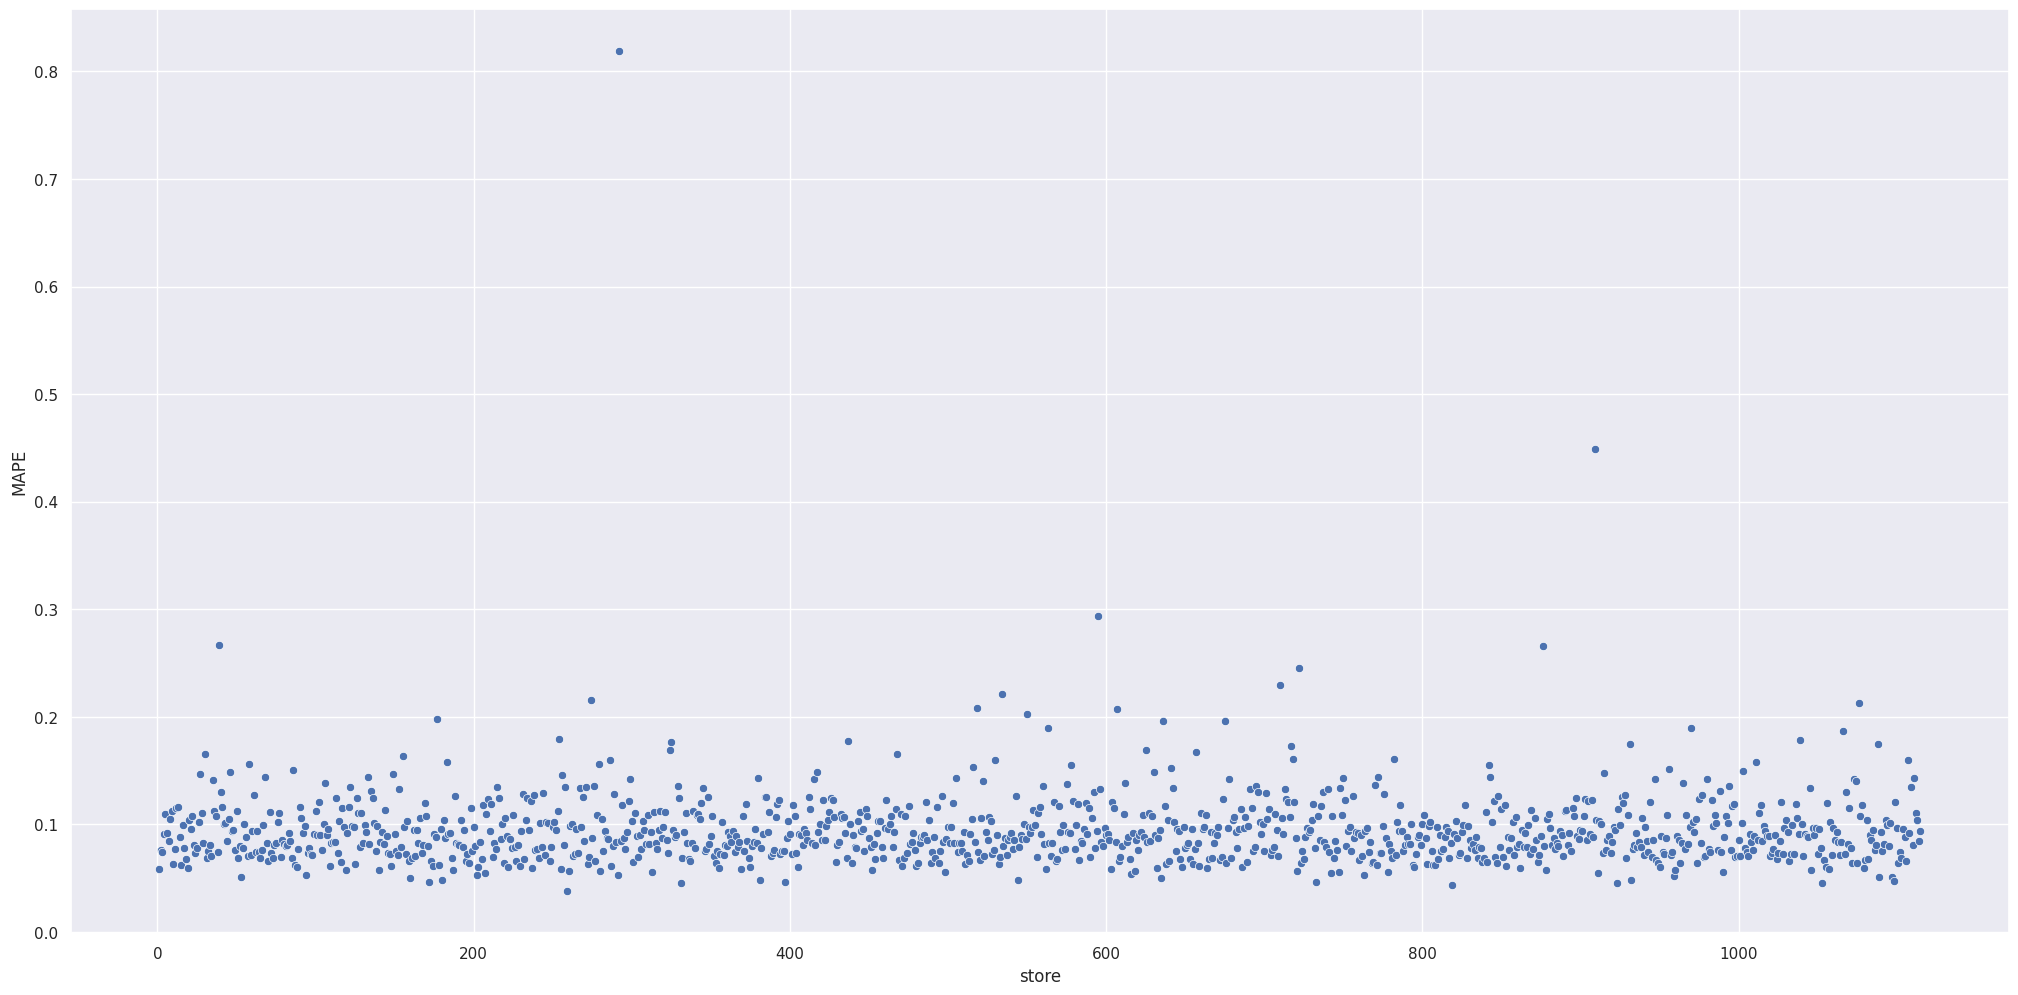

In [76]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [77]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']]\
    .apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$143,656,736.00"
1,worst_scenario,"R$142,934,693.20"
2,best_scenario,"R$144,378,781.38"


## 9.3 Machine Learning Performance

<Axes: xlabel='predictions', ylabel='error'>

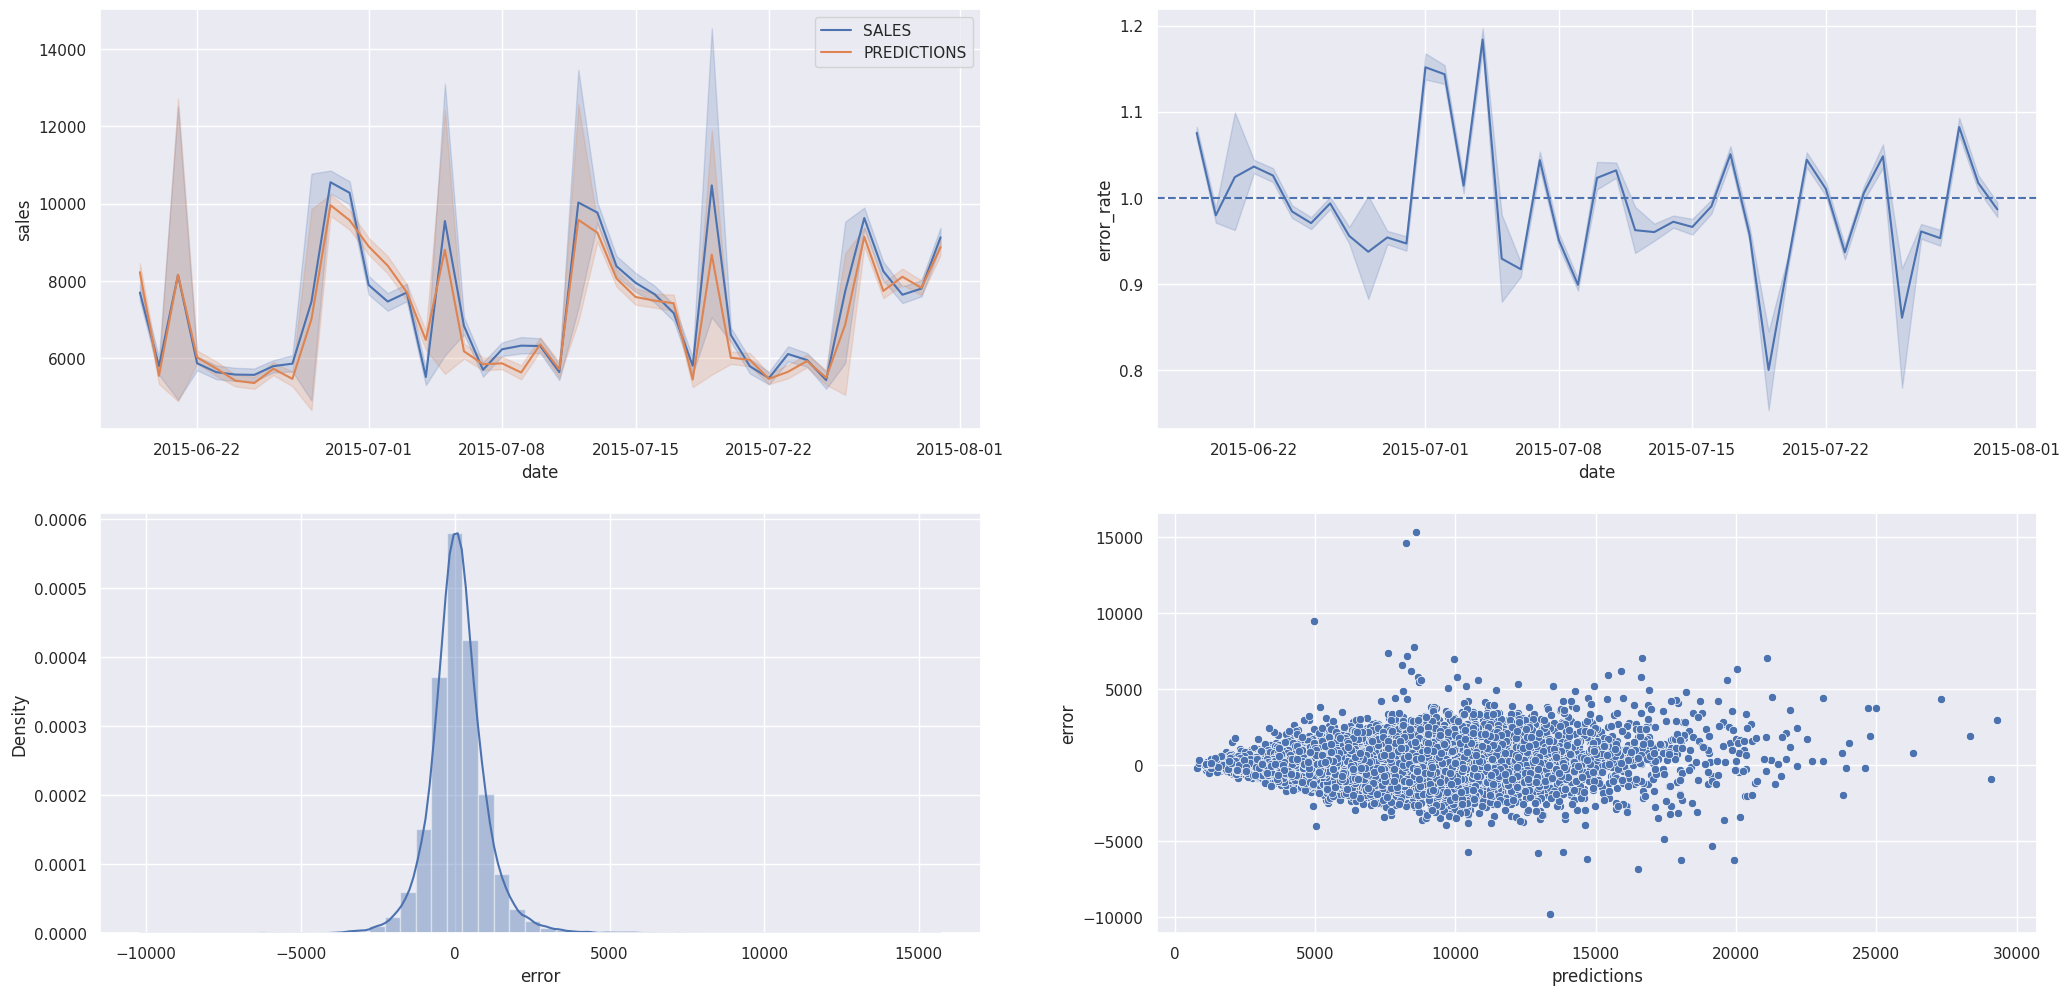

In [80]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )
plt.subplot( 2, 2, 4 )
sns.scatterplot(x='predictions', y='error', data=df9)

# 10.0 - Deply Model to production

In [87]:
# Save Trained Model
pickle.dump(model_xgb_tuned, open('../model/model_rossmann.pkl', 'wb'))

In [98]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = '/home/rafael/workspace/ds-producao/'
        self.competition_distance_scaler = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )

    def data_cleaning( self, df1 ):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',\
                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',\
                    'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                        else x['competition_open_since_month'], axis=1 )
        
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )
                                                       else x['competition_open_since_year'], axis=1 )
        
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
        
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )
       
        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1
    
    def feature_engineering( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        # df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        
        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )

        return df2

    def data_preparation( self, df5 ):
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values )
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',\
                          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',\
                          'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos' ]
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        return original_data.to_json( orient='records', date_format='iso' )



## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, Request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/home/rafael/workspace/ds-producao/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask( __name__ )

@app.route('rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = Request.get_json()

    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #multiple
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossmann class
        pipeline = Rossmann()
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        return df_response
    
    else:
        return Response('{}', status=400, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0')


## 10.3 API Tester

In [3]:
# Loading test dataset
df10 = pd.read_csv( '../data/test.csv' )

In [14]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([20])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [16]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [19]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )


Status Code 200


In [22]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction'] ) )


Store Number 20 will sell R$271,858.99 in the next 6 weeks
